# Timeseries Forecasting. Classic and DL methods.

A temperature forecasting example.  

Predicting the temperature 24 hours in the future, given a timeseries of hourly measurements of quantities such as atmospheric pressure and humidity

# 1. Load Libraries

In [1]:
import numpy as np
import pandas as pd
from warnings import simplefilter
###### TF / KERAS ########
#from tensorflow import keras
#from tensorflow.keras import layers
#### Pytorch ###########
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
#import lightning as L
###########################
import plotly.express as px
import plotly.graph_objects as go
import os
import plotly.io as pio
pio.templates.default = "plotly_white"
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import os, pathlib, shutil, random, urllib, zipfile

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(18, 9))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

# 2. Load Data.

In [ ]:
# Run this cell only once

url = "https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip"
extract_dir = "."

zip_path, _ = urllib.request.urlretrieve(url)
with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(extract_dir)
    
jena = pd.read_csv('jena_climate_2009_2016.csv')
jena.to_parquet('jena_climate_2009_2016.parquet')

In [28]:
jena = pd.read_parquet('jena_climate_2009_2016.parquet')
jena['Date Time'] = pd.to_datetime(jena['Date Time'])
#jena = jena.set_index("Date Time").sort_index()
jena.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420451 entries, 0 to 420450
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Date Time        420451 non-null  datetime64[ns]
 1   p (mbar)         420451 non-null  float64       
 2   T (degC)         420451 non-null  float64       
 3   Tpot (K)         420451 non-null  float64       
 4   Tdew (degC)      420451 non-null  float64       
 5   rh (%)           420451 non-null  float64       
 6   VPmax (mbar)     420451 non-null  float64       
 7   VPact (mbar)     420451 non-null  float64       
 8   VPdef (mbar)     420451 non-null  float64       
 9   sh (g/kg)        420451 non-null  float64       
 10  H2OC (mmol/mol)  420451 non-null  float64       
 11  rho (g/m**3)     420451 non-null  float64       
 12  wv (m/s)         420451 non-null  float64       
 13  max. wv (m/s)    420451 non-null  float64       
 14  wd (deg)         420

In [29]:
date = pd.date_range(start='2009-01-01 00:10:00', periods=jena.shape[0], freq='10T')

jena = jena.set_index(date)
jena = jena.drop(columns = ['Date Time'])
pd.infer_freq(jena.index) # Infer Frequency for Decomposition jena.set_index("Date Time")
jena.head()
# Jena Dataset comes without freq property what it is important to have for forecasting models

'N'

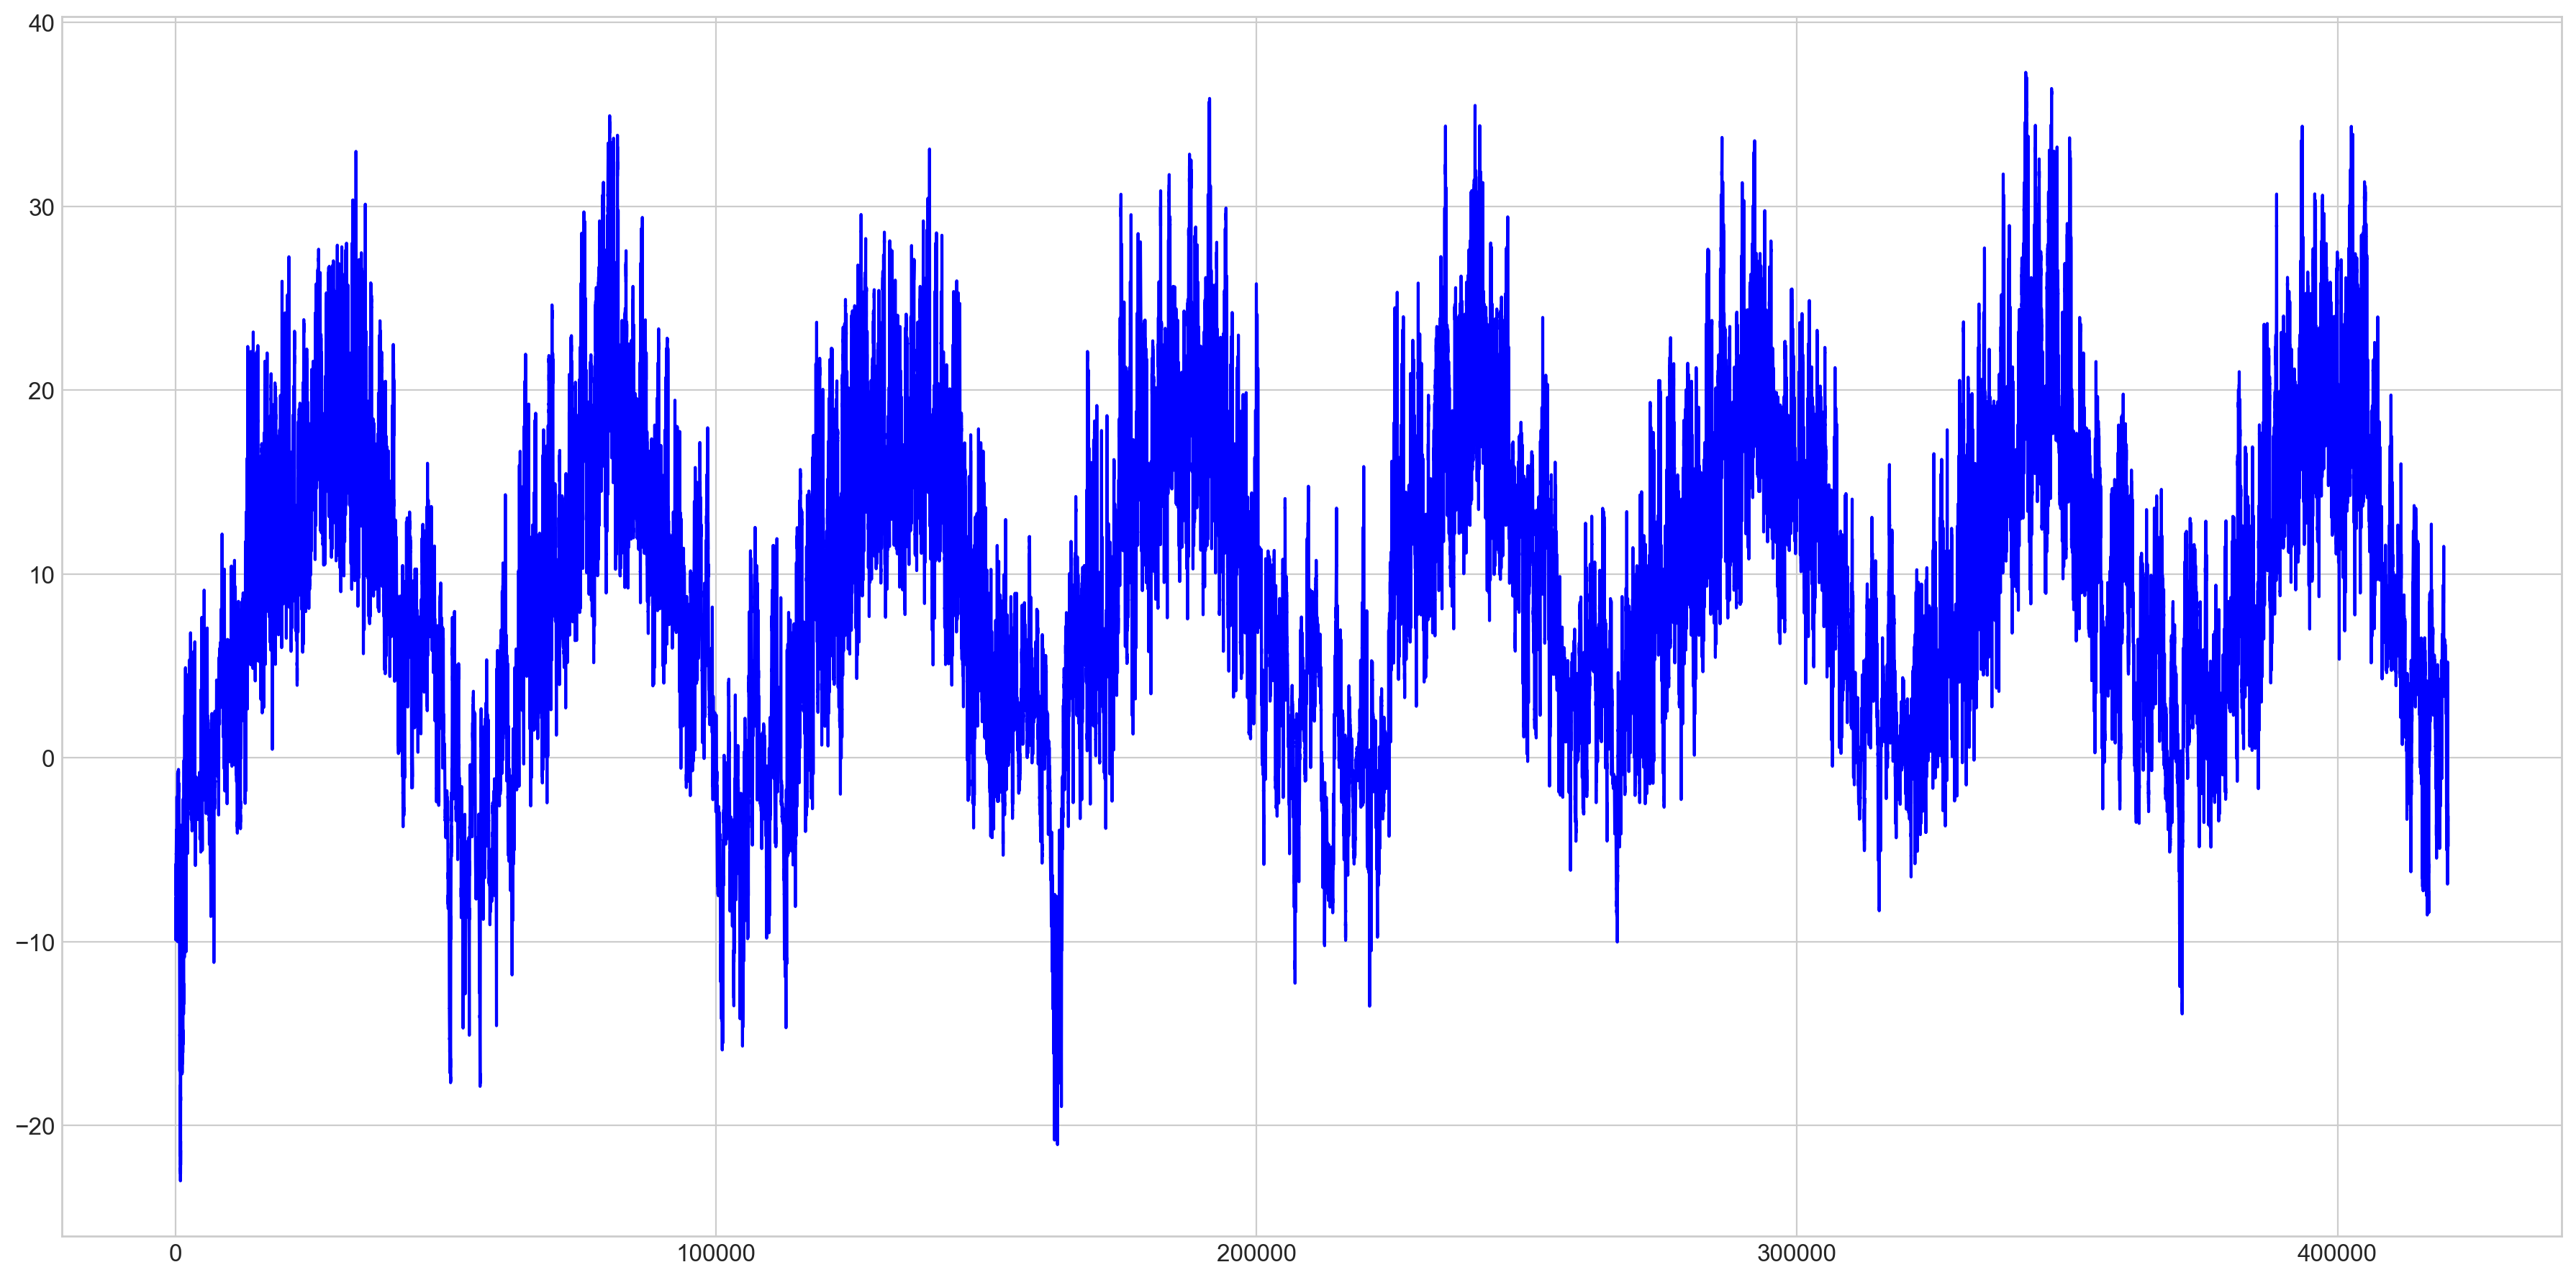

In [37]:
# Plot temperature target.T
features = jena.loc[:,['p (mbar)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)']]
target = jena.loc[:,'T (degC)']

plt.plot(range(len(target)), target.values, c='b')
plt.grid(True)

# The stationality can be seen in this plot, also some extreme values

In [46]:
samples = 365*24*6
print('One year has samples', samples)


One year has samples 52560


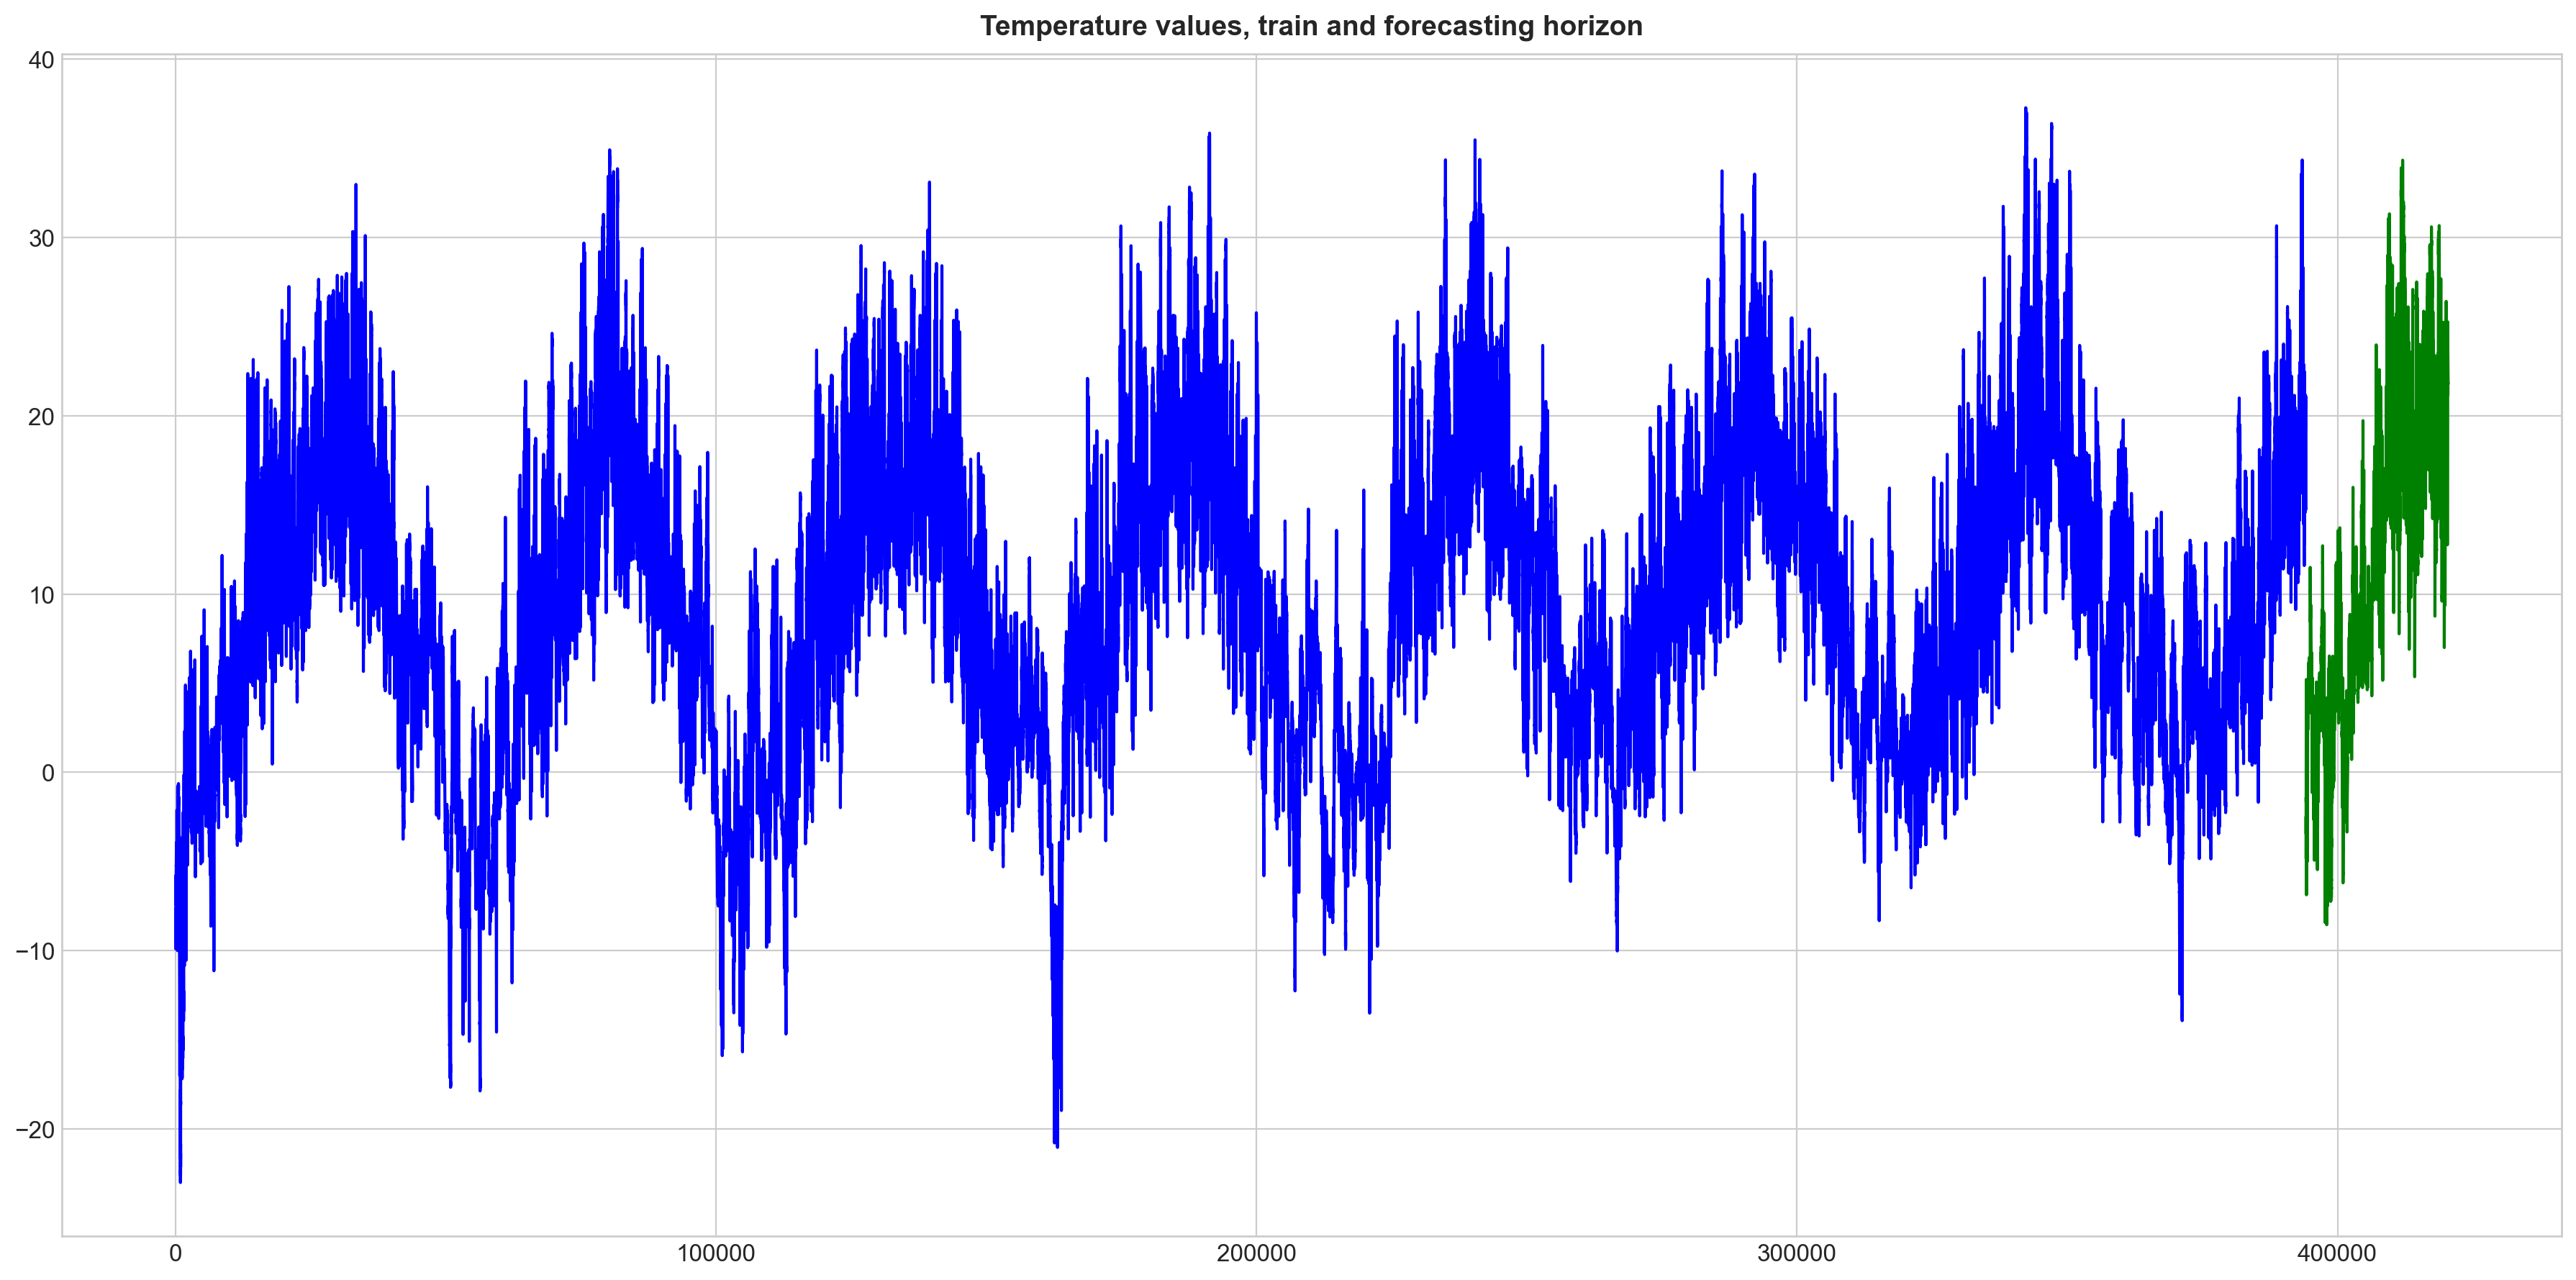

In [49]:
value_to_fore = round(samples/2)
plt.plot(range(len(target) - value_to_fore), target.values[0:len(target) - value_to_fore], c='b', label = 'All data')

plt.plot(range(len(target)-(value_to_fore-1),len(target)), target.values[:-value_to_fore:-1], c='g', label ='forecasted')
plt.title('Temperature values, train and forecasting horizon')
plt.grid(True)

## Seasonal and Trend Decomposition

In [50]:
print(6*24*365) # Lectures per year, if one lecture every 10 min
print(24*365)# lectures per year, one lecture per hour

52560
8760


One of the easiest ways of estimating trends is by using a moving average along the time series

<AxesSubplot: title={'center': 'Temperature Average ºC - 4 Years Moving Average'}>

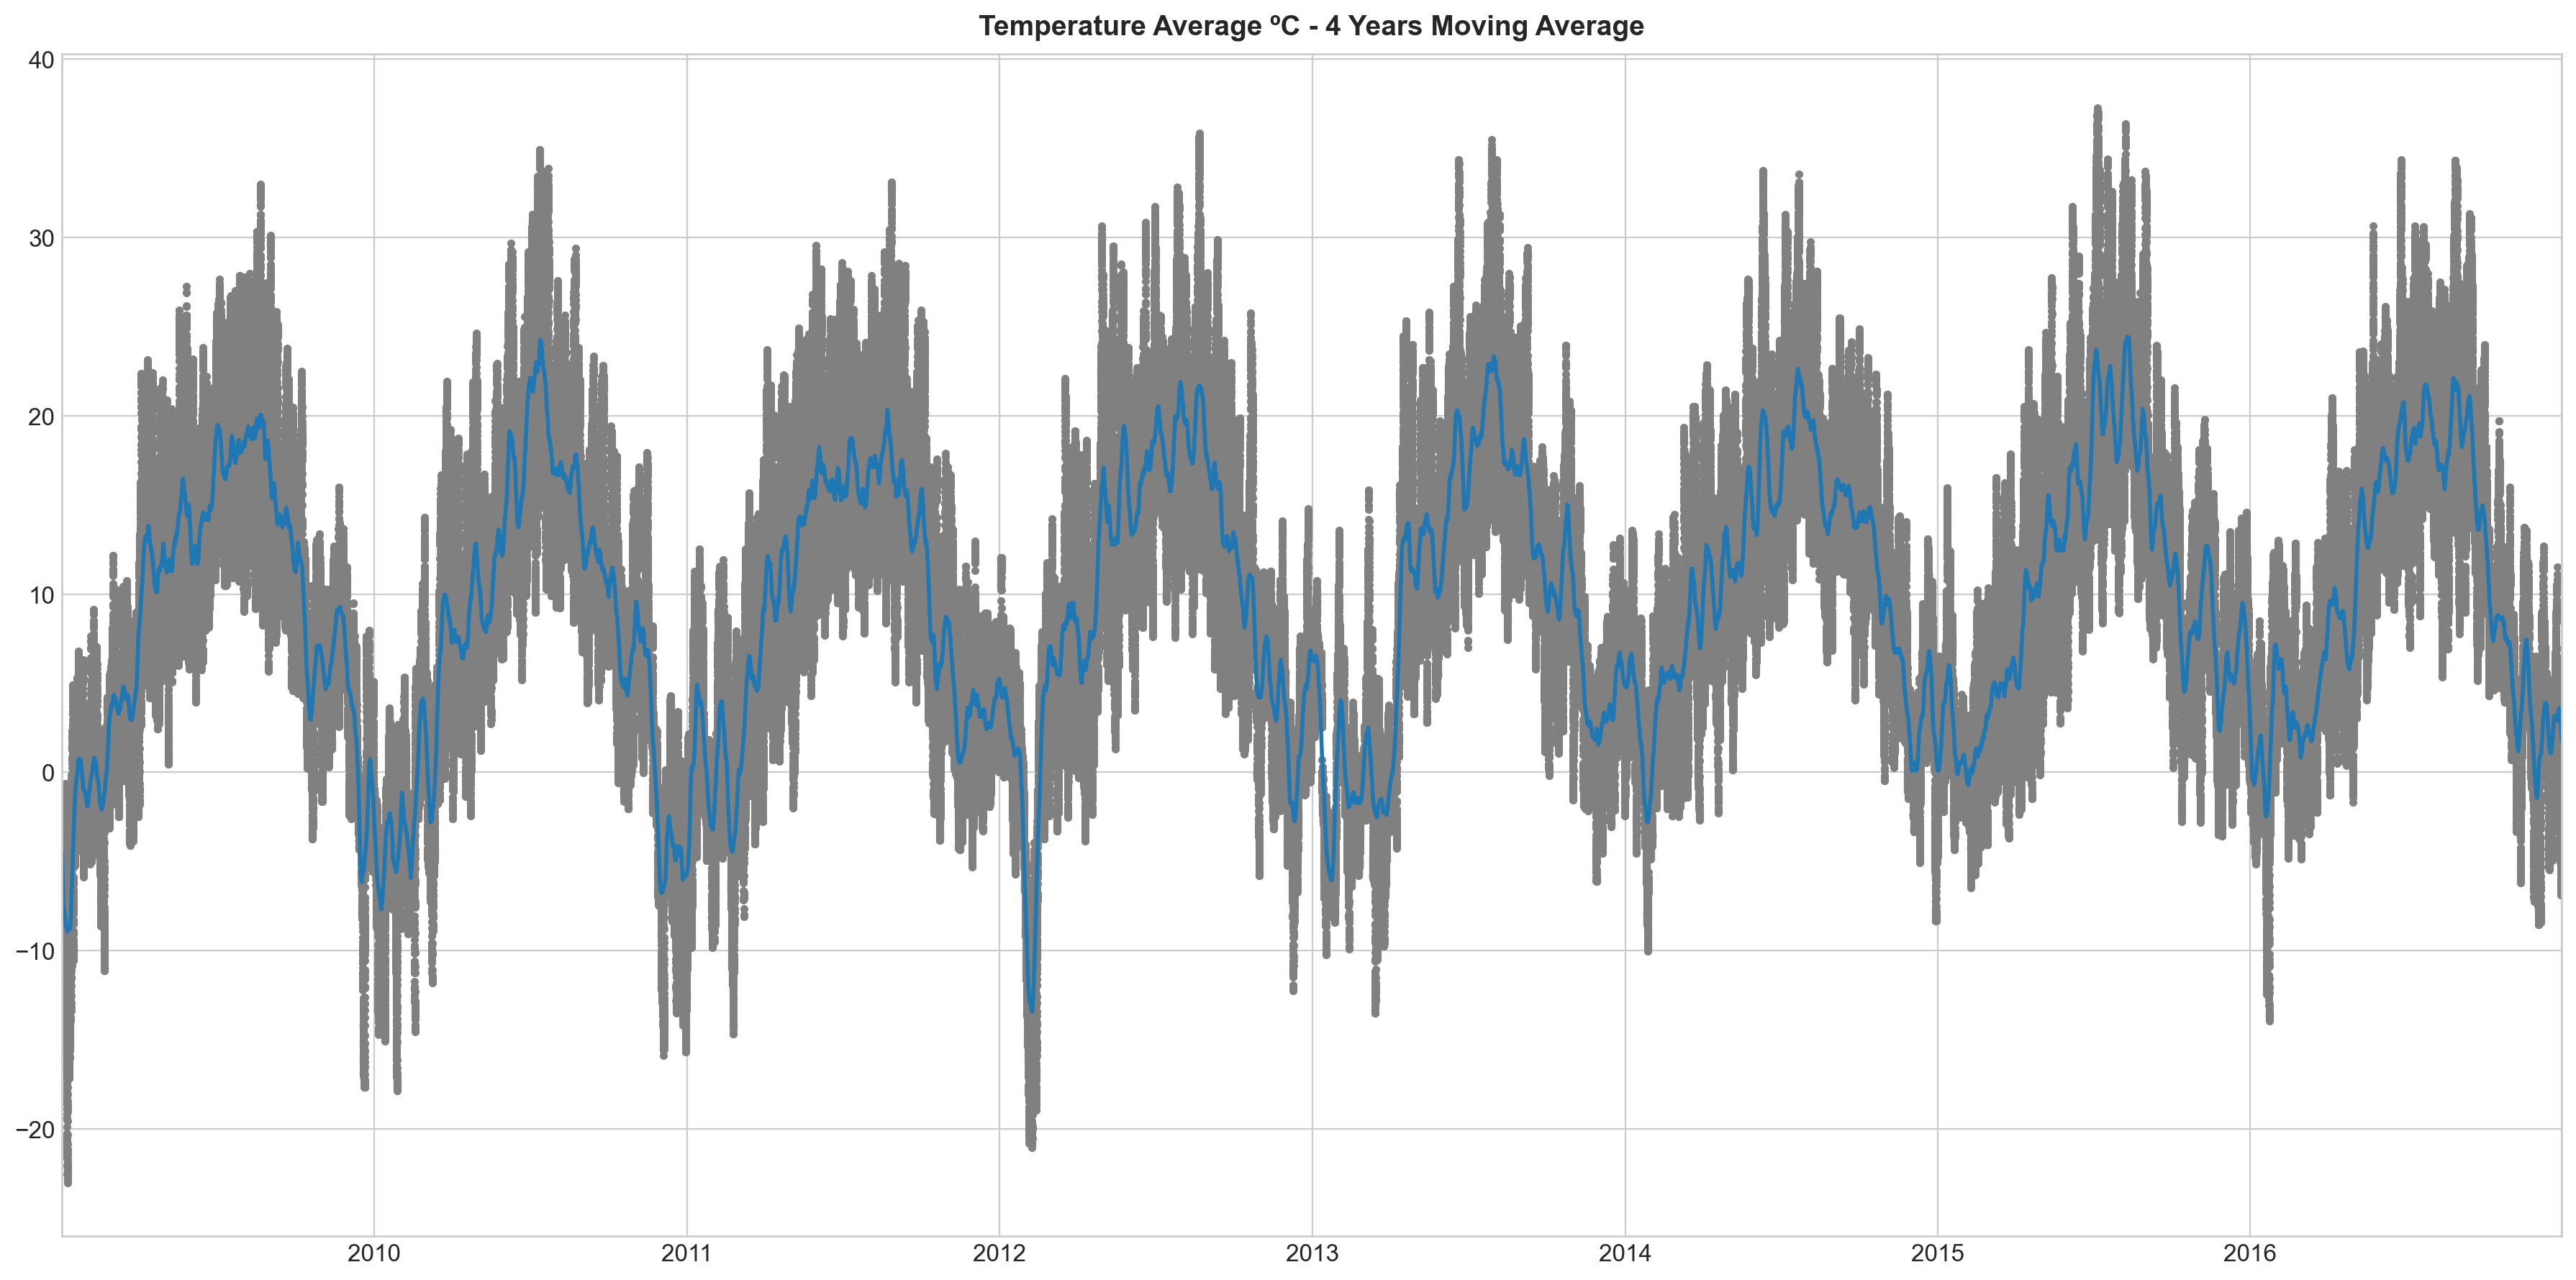

In [51]:
moving_average = target.rolling(
    window=365*4,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = target.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=2, title="Temperature Average ºC - 4 Years Moving Average", legend=False,
)

# 3. A Linear Regression Forecasting Model. Pure Trend using Statsmodels

From now on, however, we'll use a function from the statsmodels library called DeterministicProcess. Using this function will help us avoid some tricky failure cases that can arise with time series and linear regression. The order argument refers to polynomial order: 1 for linear, 2 for quadratic, 3 for cubic, and so on.

In [52]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=target.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=2,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()
#X.reset_index(inplace=True)
X.head()

const  trend  trend_squared
2009-01-01 00:10:00    1.0    1.0            1.0
2009-01-01 00:20:00    1.0    2.0            4.0
2009-01-01 00:30:00    1.0    3.0            9.0
2009-01-01 00:40:00    1.0    4.0           16.0
2009-01-01 00:50:00    1.0    5.0           25.0

In [53]:
from sklearn.linear_model import LinearRegression

y = target  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

In [54]:
# Forecasting with a Linear Model
X = dp.out_of_sample(steps=10000)

y_fore = pd.Series(model.predict(X), index=X.index)
#y_fore = pd.Series(model.predict(X), index = range(len(X)))
y_fore.head()

2016-12-29 19:20:00    10.606739
2016-12-29 19:30:00    10.606741
2016-12-29 19:40:00    10.606742
2016-12-29 19:50:00    10.606743
2016-12-29 20:00:00    10.606744
Freq: 10T, dtype: float64

In [55]:
print('Model Intercept {}, Model Coeffs {}'.format(model.intercept_, model.coef_))

Model Intercept 0.0, Model Coeffs [ 7.39763237e+00  1.40025181e-05 -1.51503653e-11]


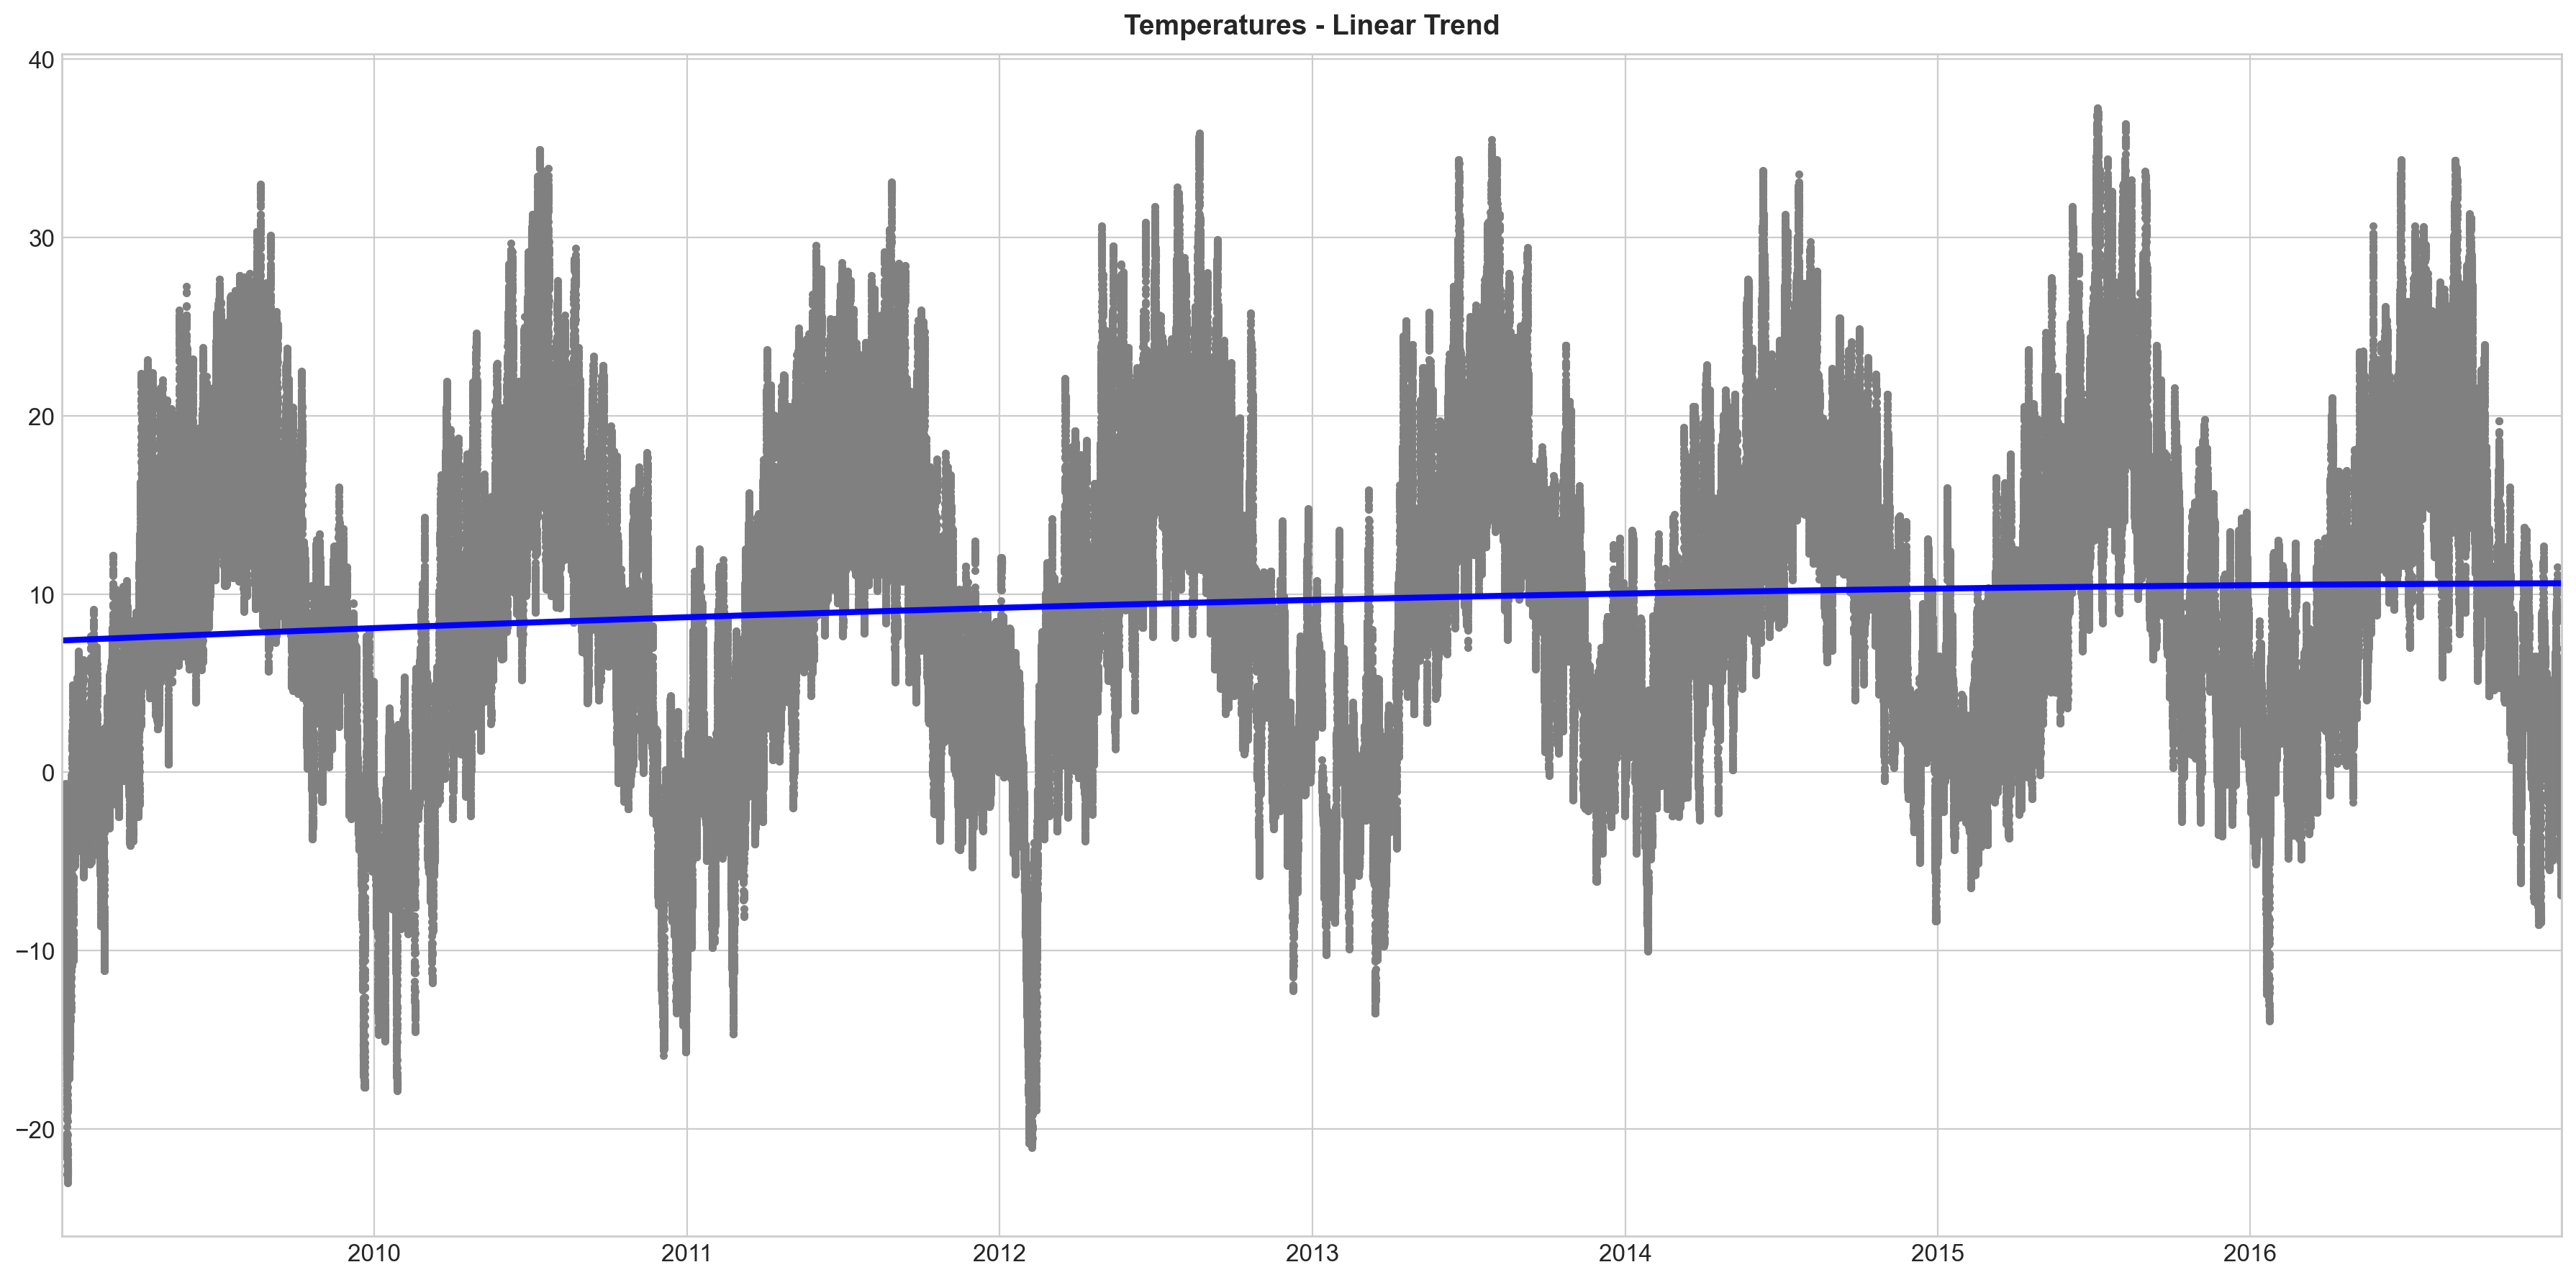

In [56]:
ax = target.plot(style=".", color="0.5", title="Temperatures - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, color = 'b', label="Trend")

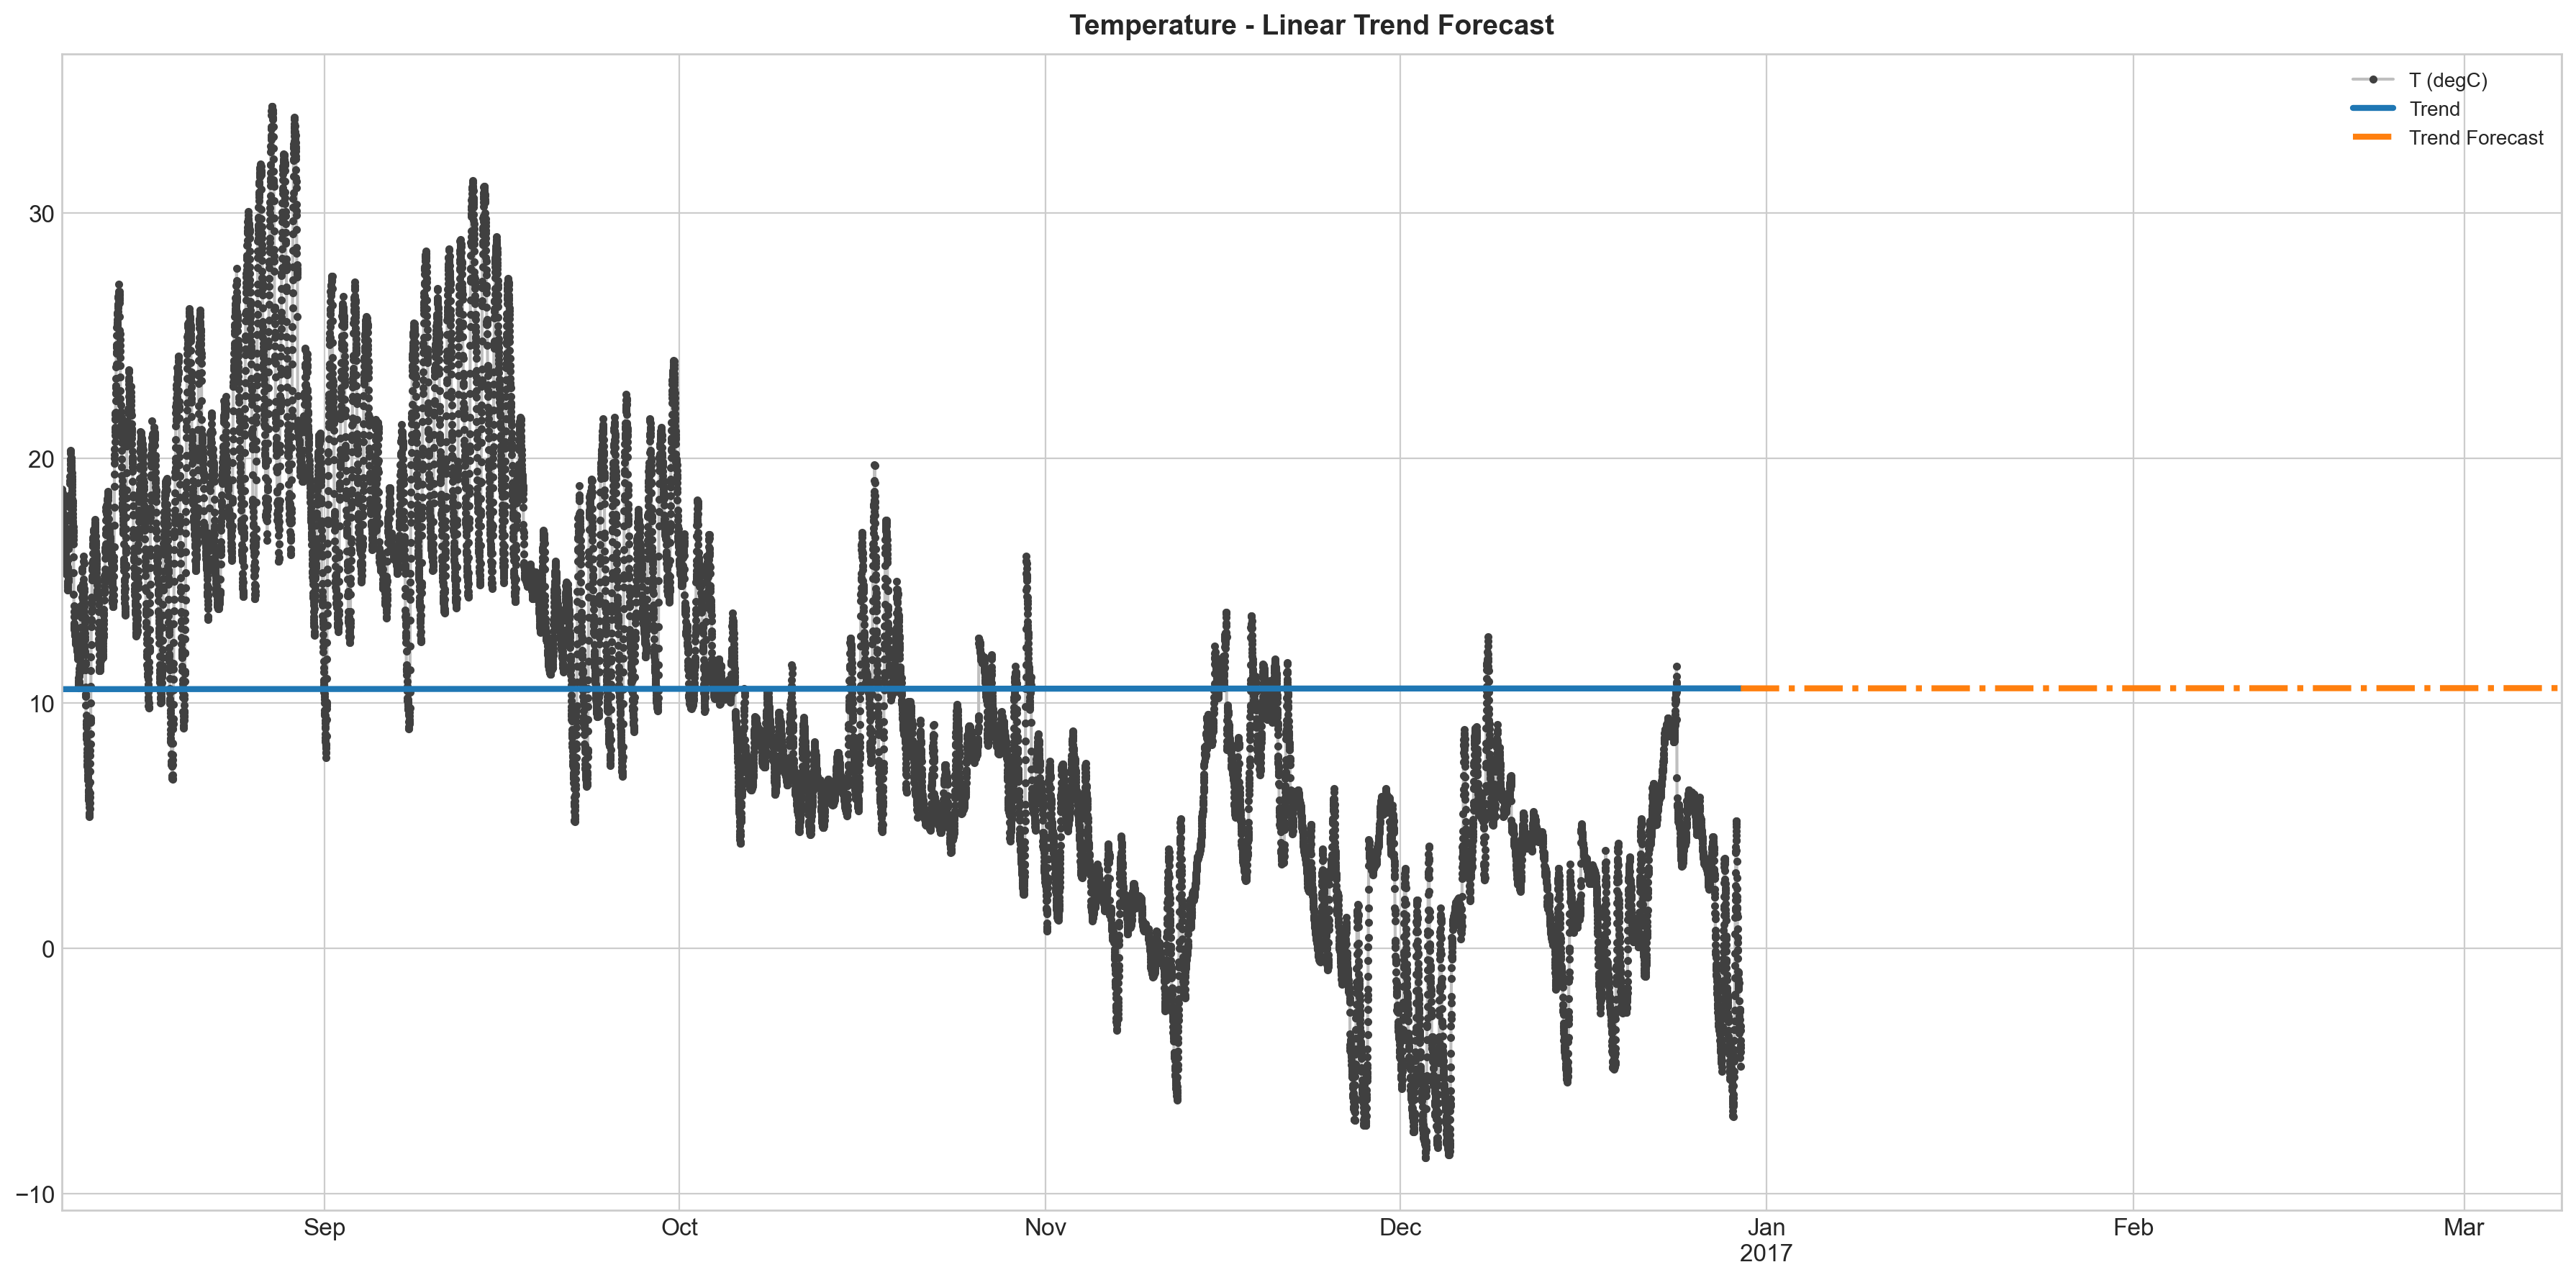

In [57]:
ax = target[400000:].plot(title="Temperature - Linear Trend Forecast", **plot_params)
ax = y_pred[400000:].plot(ax=ax, linewidth=3,ls='-', label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, ls= '-.', label="Trend Forecast", color="C1")
_ = ax.legend()

# 4. SEASONAL DECOMPOSE WITH STATSMODELS.TSA

Time Series can be decomposed using Statsmodels TSA library

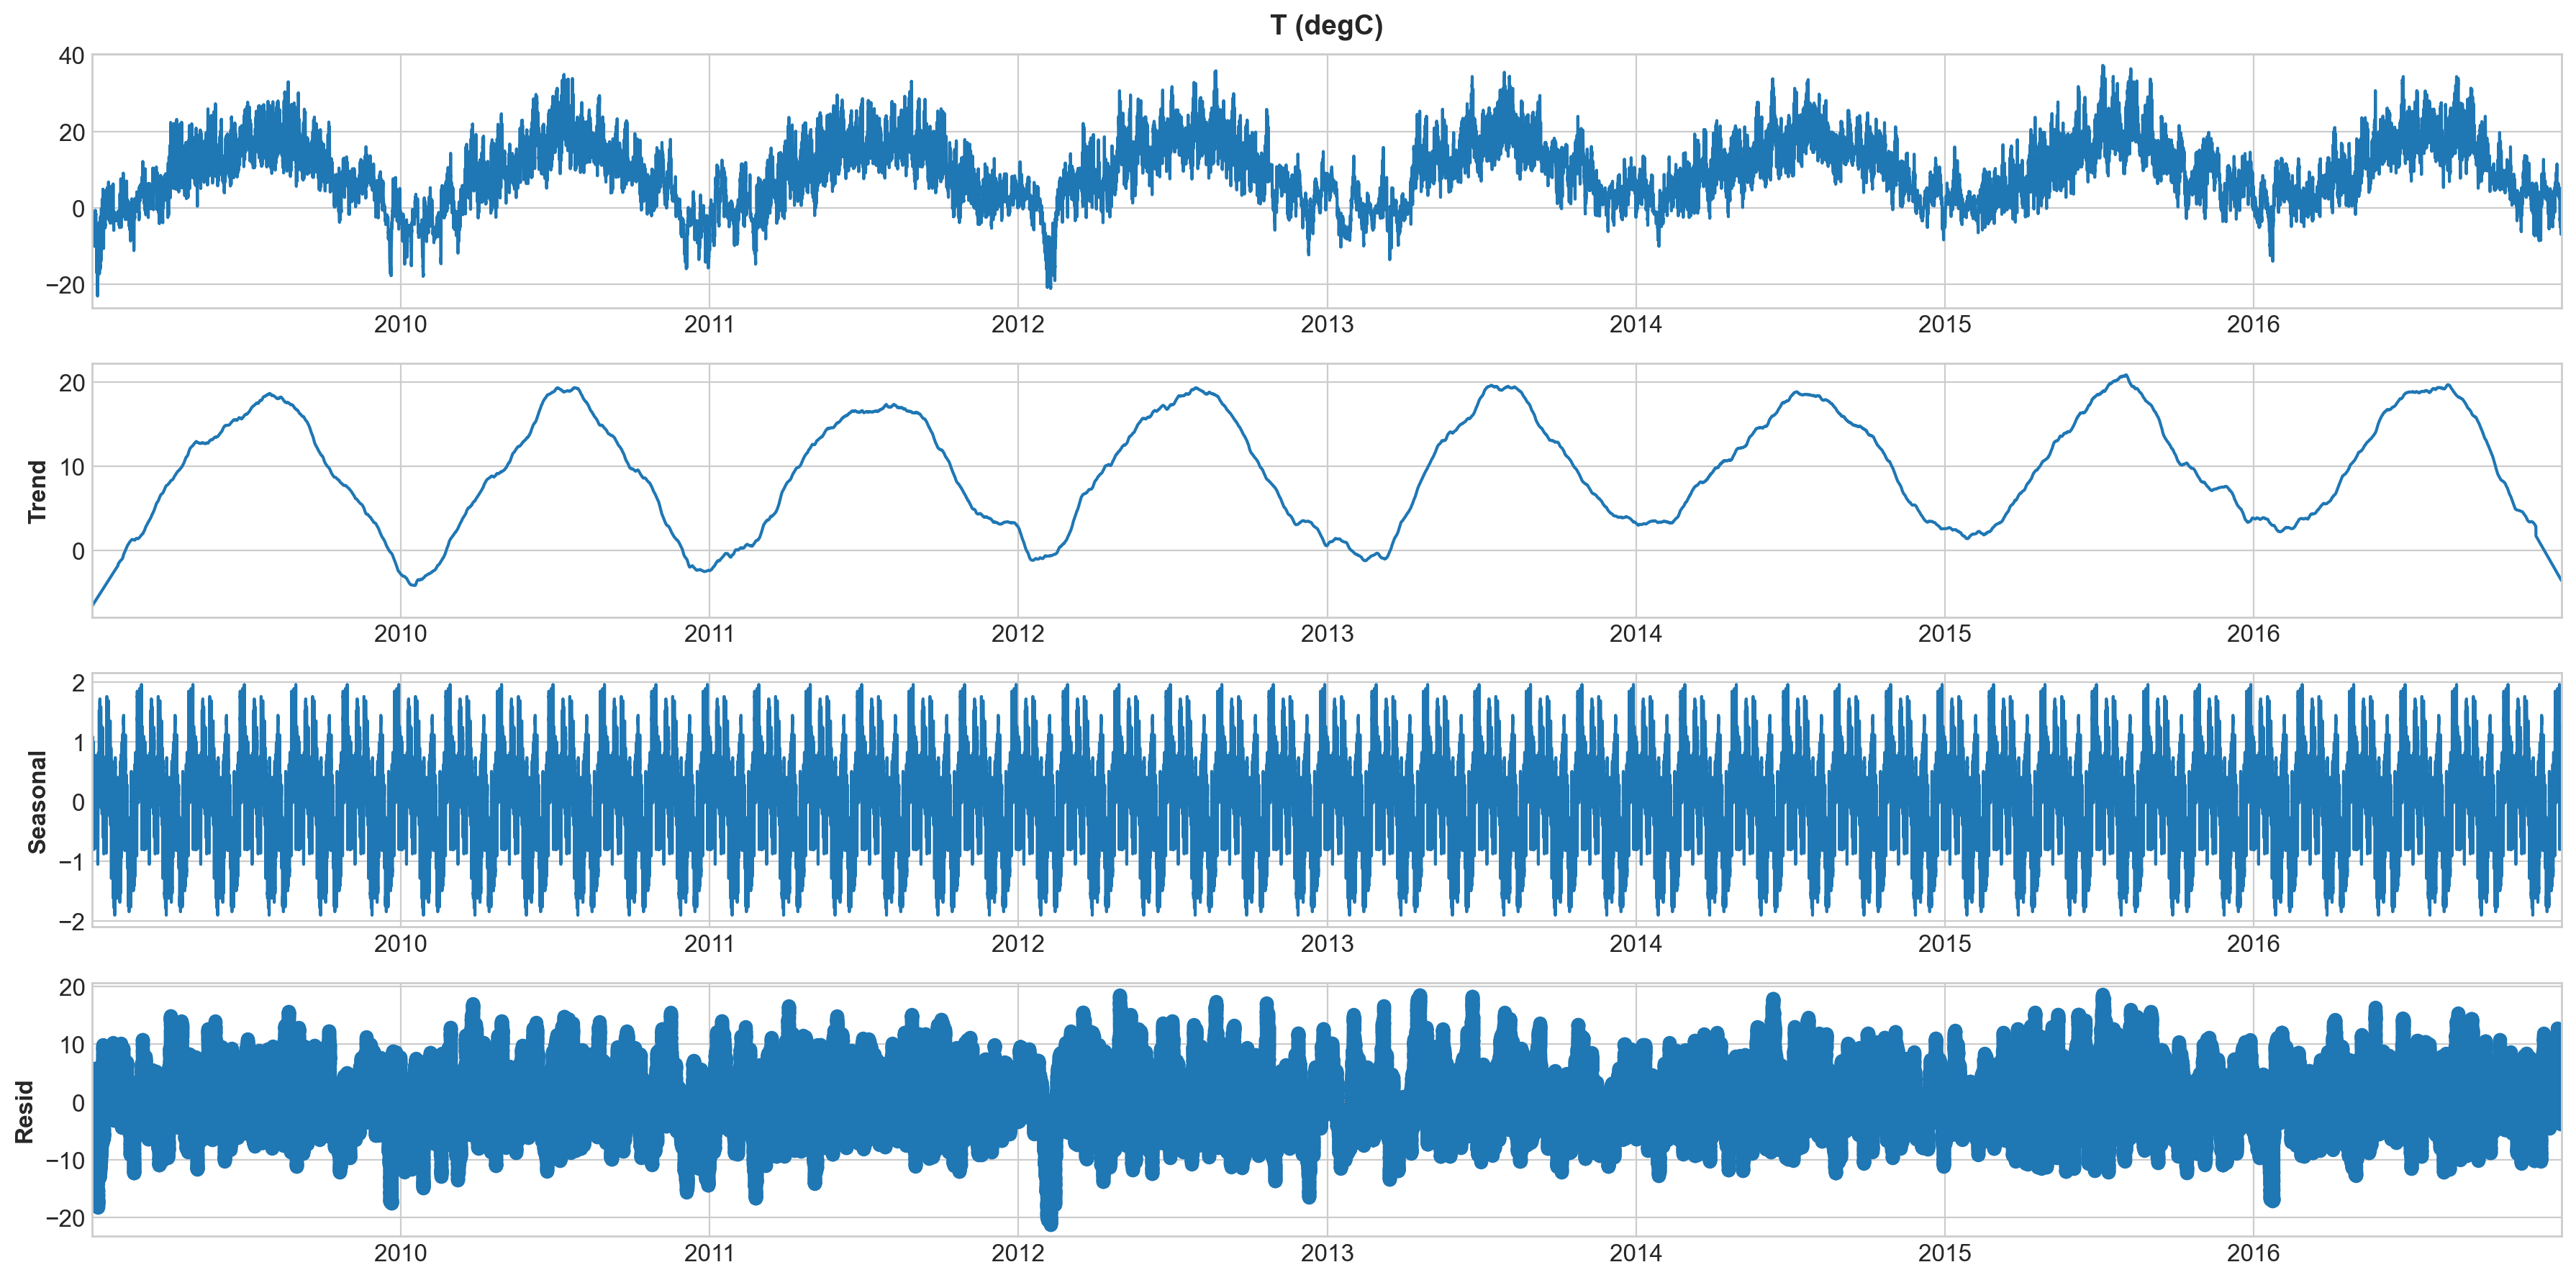

In [58]:

from statsmodels.tsa.seasonal import seasonal_decompose # Simple seasonal decompose

res = seasonal_decompose(target, period = 8760, model= 'additive', extrapolate_trend='freq')
fig = res.plot()

Take a look at the noise component and inspect if it looks random. If there was a strong pattern, it would tell you the time series is serially auto-correlated and the model fit is suspect.

## 4.1 Decompose the time series with LOESS

Seasonal-trend decomposition (STL) uses locally estimated scatterplot smoothing (LOESS) to extract seasonality and trend from a time series. It improves on the basic additive model by handling any kind of seasonality and being more robust to outliers.

In [59]:
from statsmodels.tsa.seasonal import STL
#target = target.reset_index()
target_res = pd.Series(target.values, index=pd.date_range("1-1-2009", periods = len(target),freq='10min'))
target_res = target_res.resample('W').mean().ffill()

stl_non_robust = STL(target_res, robust =False).fit()
stl_robust = STL(target_res, robust=True).fit()


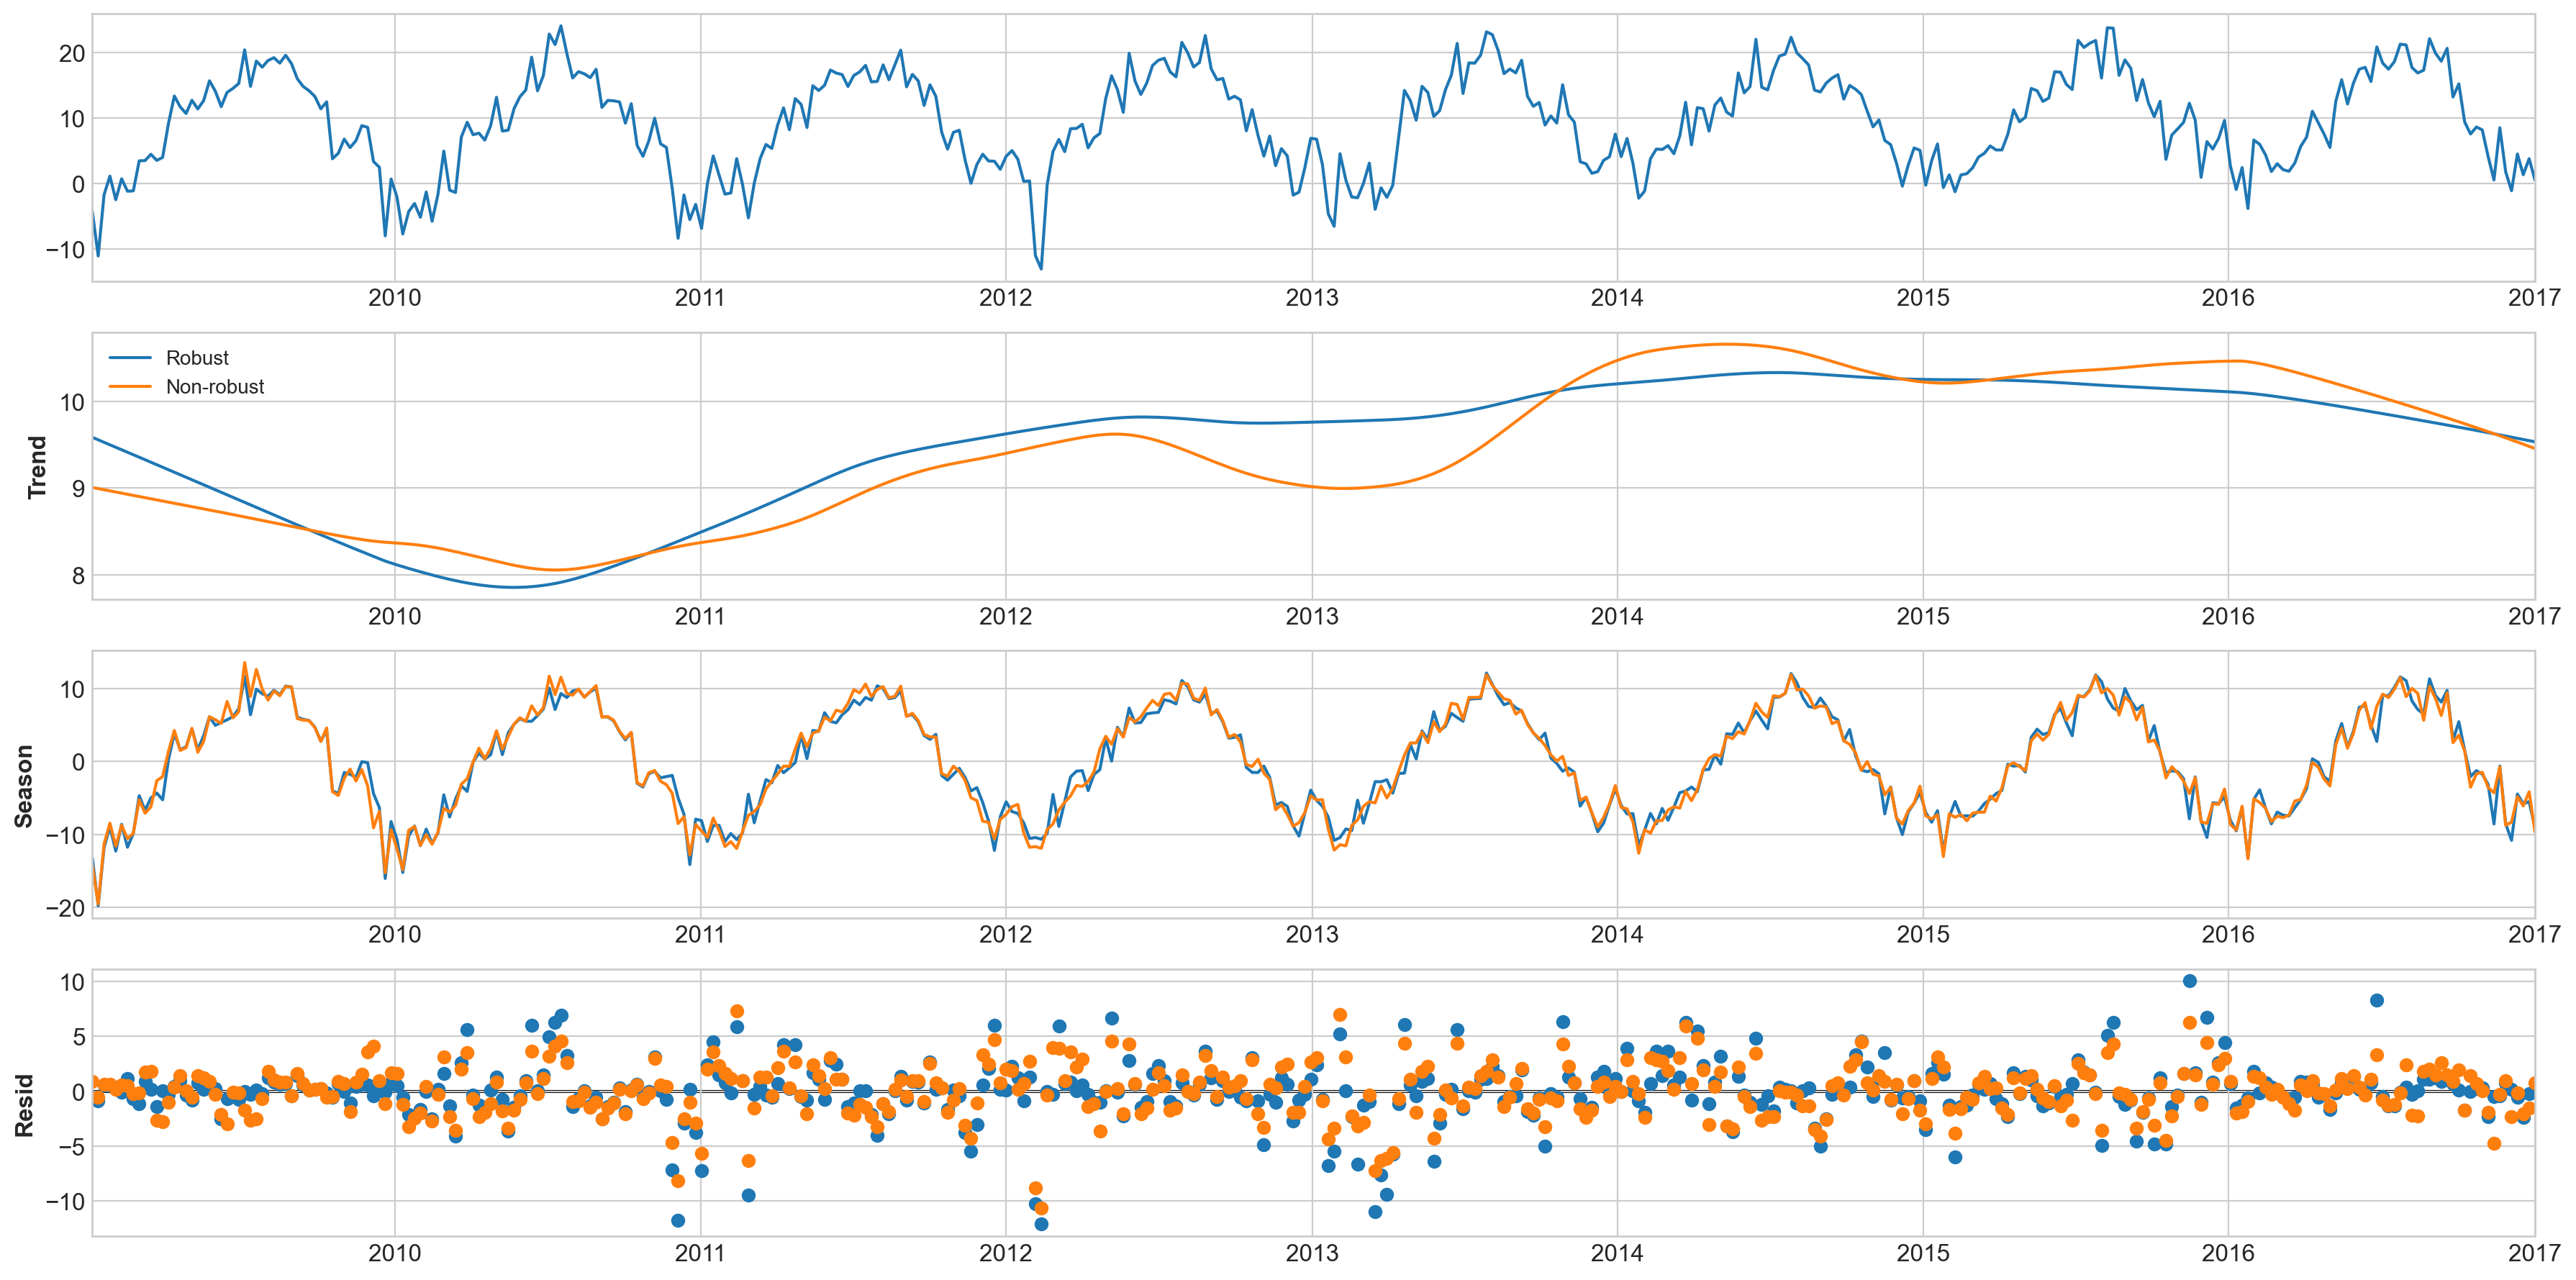

In [60]:
def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ["trend", "seasonal", "resid"]
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == "resid":
            ax.plot(series, marker="o", linestyle="none")
        else:
            ax.plot(series)
            if comp == "trend":
                ax.legend(legend, frameon=False)

fig = stl_robust.plot()
add_stl_plot(fig, stl_non_robust, ["Robust", "Non-robust"])


## 4.2 Fourier Features and the Periodogram

The kind of feature we discuss now are better suited for long seasons over many observations where indicators would be impractical. Instead of creating a feature for each date, Fourier features try to capture the overall shape of the seasonal curve with just a few features.

Let's take a look at a plot for the annual season in Trigonometry. Notice the repetitions of various frequencies: a long up-and-down movement three times a year, short weekly movements 52 times a year, and perhaps others.

It is these frequencies within a season that we attempt to capture with Fourier features. The idea is to include in our training data periodic curves having the same frequencies as the season we are trying to model. The curves we use are those of the trigonometric functions sine and cosine.

Fourier features are pairs of sine and cosine curves, one pair for each potential frequency in the season starting with the longest. Fourier pairs modeling annual seasonality would have frequencies: once per year, twice per year, three times per year, and so on.

Choosing Fourier features with the Periodogram

How many Fourier pairs should we actually include in our feature set? We can answer this question with the periodogram. The periodogram tells you the strength of the frequencies in a time series. Specifically, the value on the y-axis of the graph is (a ** 2 + b ** 2) / 2, where a and b are the coefficients of the sine and cosine at that frequency (as in the Fourier Components plot above).

In [61]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([0.001, 0.01, 0.1, 1, 2, 4, 6, 12, 26, 52, 104])
    
    ax.set_xticklabels(
        
        [   "Eight -Years (0.001)",
            "Four - Years (0.01)",
            "Bi-Year (0.1)",
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

<AxesSubplot: title={'center': 'Periodogram'}, ylabel='Variance'>

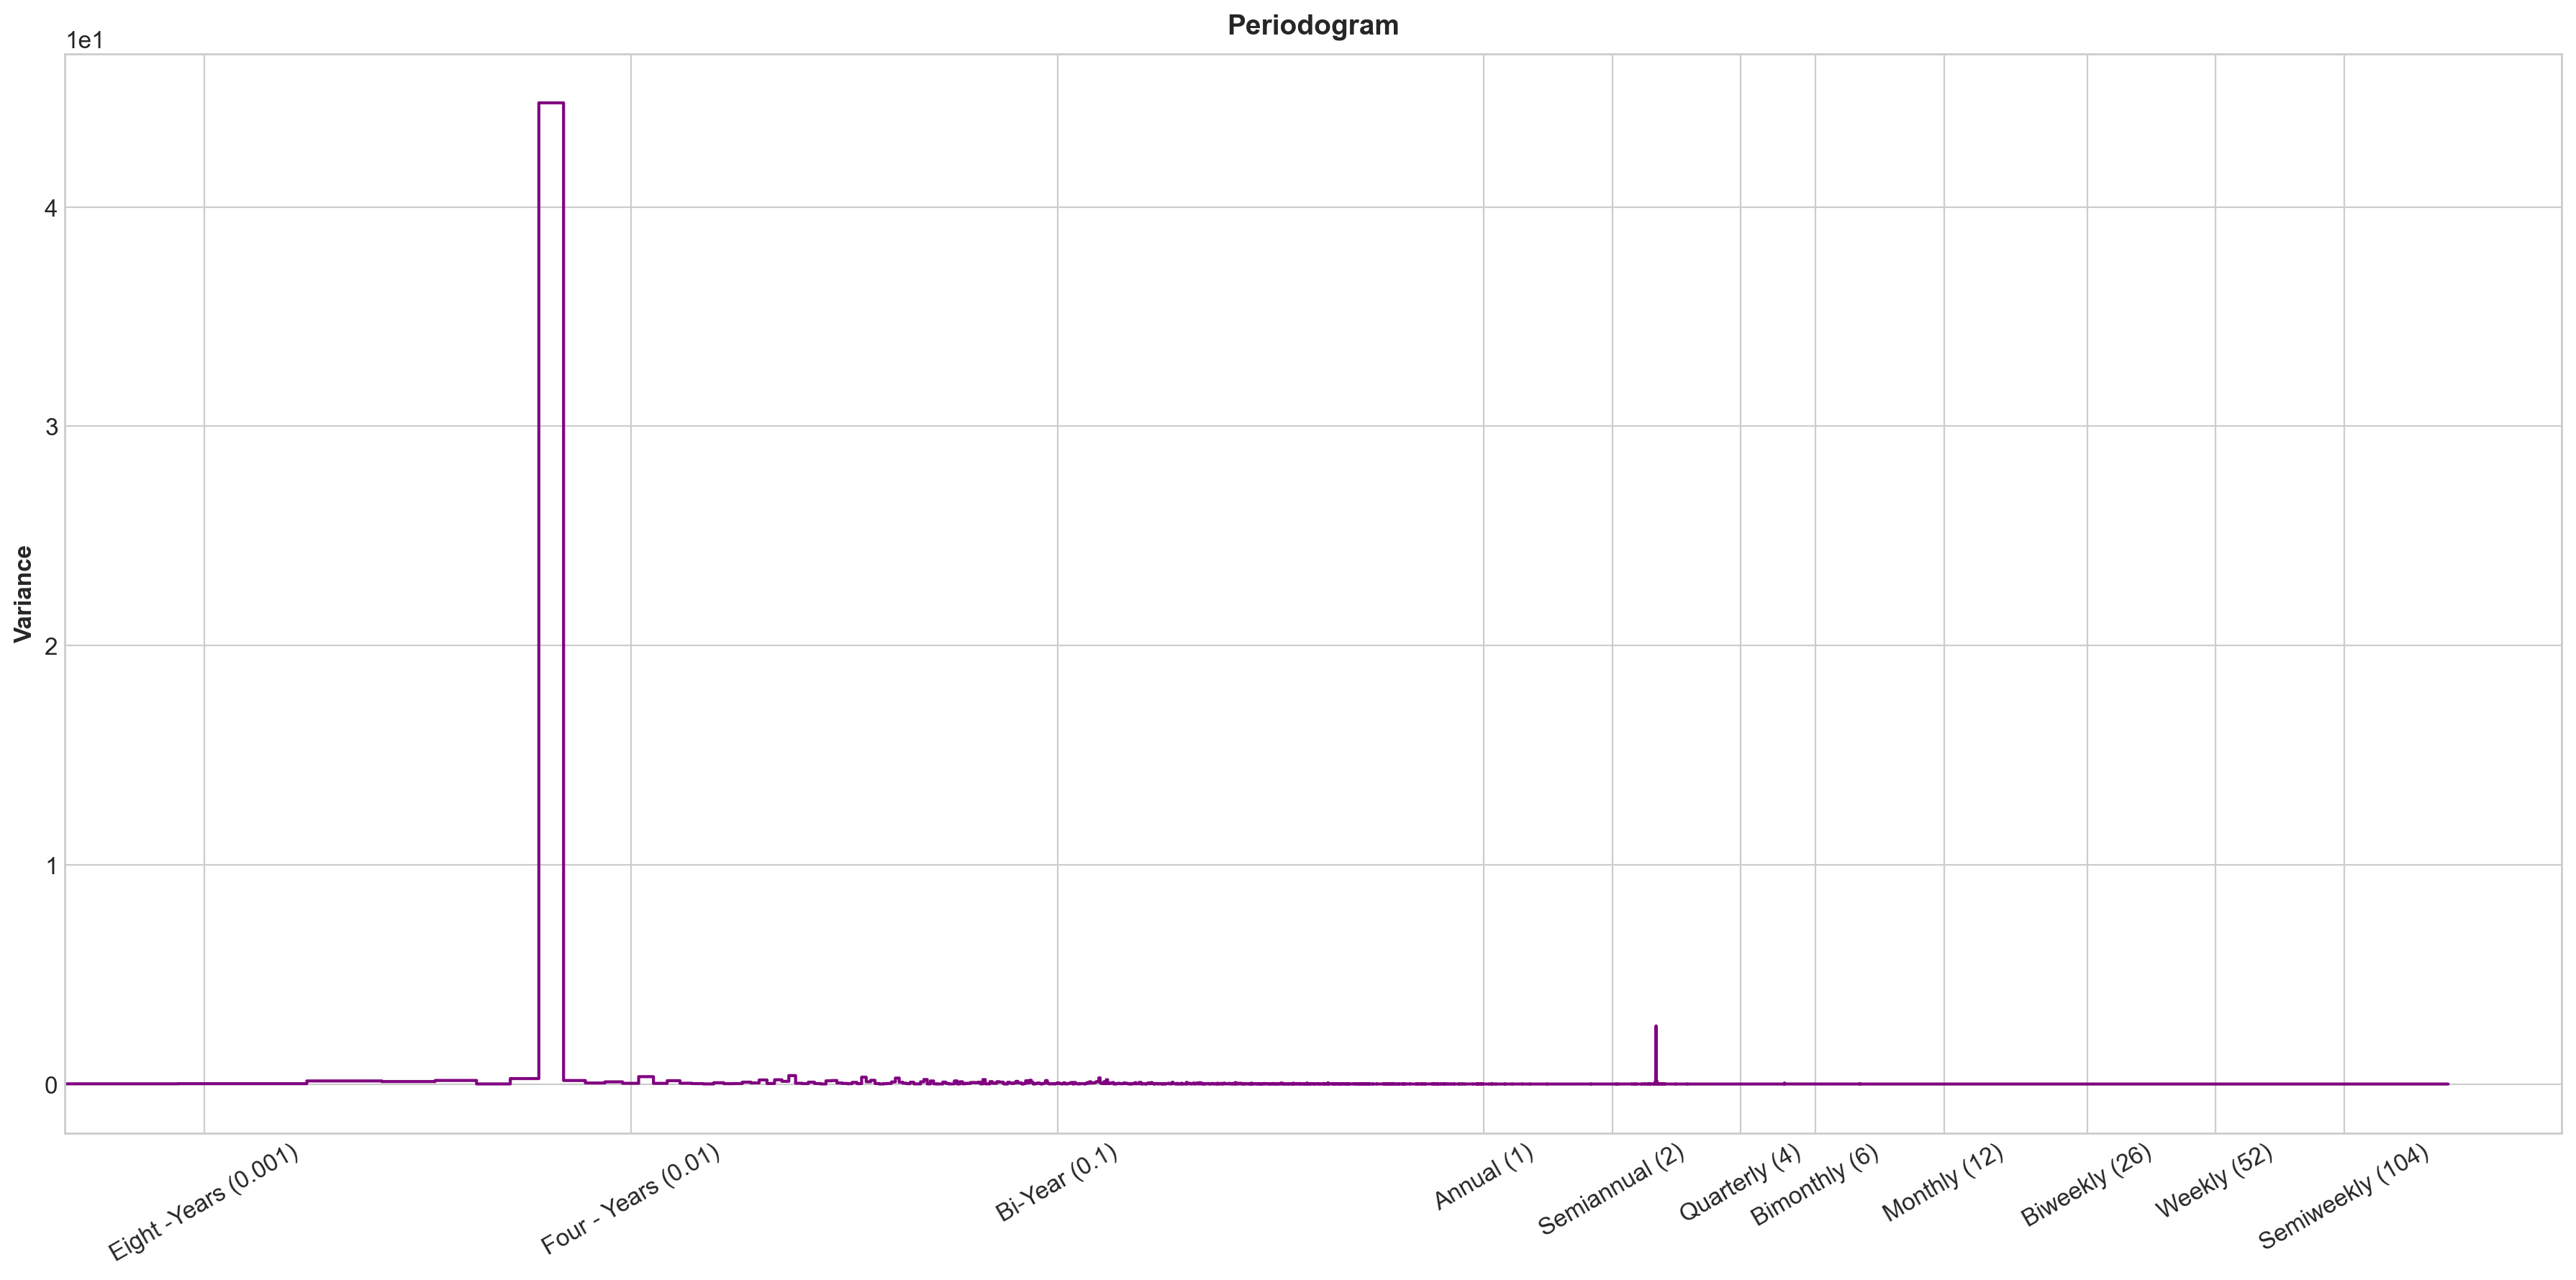

In [62]:
jena_copy = jena.copy()

target = jena_copy.loc[:,'T (degC)']
# To use the peridodograma the target index need to be a datetime index
plot_periodogram(target) 

There are some clear patterns in the periodogram, one every 6 months, another one aprox. every 5 years (El niño), 3 years.

In [64]:
target_new = jena_copy.loc[:,['T (degC)']]
target_new.head()


T (degC)
2009-01-01 00:10:00     -8.02
2009-01-01 00:20:00     -8.41
2009-01-01 00:30:00     -8.51
2009-01-01 00:40:00     -8.31
2009-01-01 00:50:00     -8.27

In [65]:
target_new_res = target_new.resample('D').mean()
target_new_res

T (degC)
2009-01-01 -6.810629
2009-01-02 -3.728194
2009-01-03 -5.271736
2009-01-04 -1.375208
2009-01-05 -4.867153
...              ...
2016-12-25  5.686806
2016-12-26  4.365625
2016-12-27  1.465278
2016-12-28 -2.084444
2016-12-29 -1.995776

[2920 rows x 1 columns]

Add Fourier Features

In [66]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=target_new_res.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample() 
print(X.isna().sum())

const                 0
trend                 0
s(2,7)                0
s(3,7)                0
s(4,7)                0
s(5,7)                0
s(6,7)                0
s(7,7)                0
sin(1,freq=A-DEC)     0
cos(1,freq=A-DEC)     0
sin(2,freq=A-DEC)     0
cos(2,freq=A-DEC)     0
sin(3,freq=A-DEC)     0
cos(3,freq=A-DEC)     0
sin(4,freq=A-DEC)     0
cos(4,freq=A-DEC)     0
sin(5,freq=A-DEC)     0
cos(5,freq=A-DEC)     0
sin(6,freq=A-DEC)     0
cos(6,freq=A-DEC)     0
sin(7,freq=A-DEC)     0
cos(7,freq=A-DEC)     0
sin(8,freq=A-DEC)     0
cos(8,freq=A-DEC)     0
sin(9,freq=A-DEC)     0
cos(9,freq=A-DEC)     0
sin(10,freq=A-DEC)    0
cos(10,freq=A-DEC)    0
dtype: int64


0


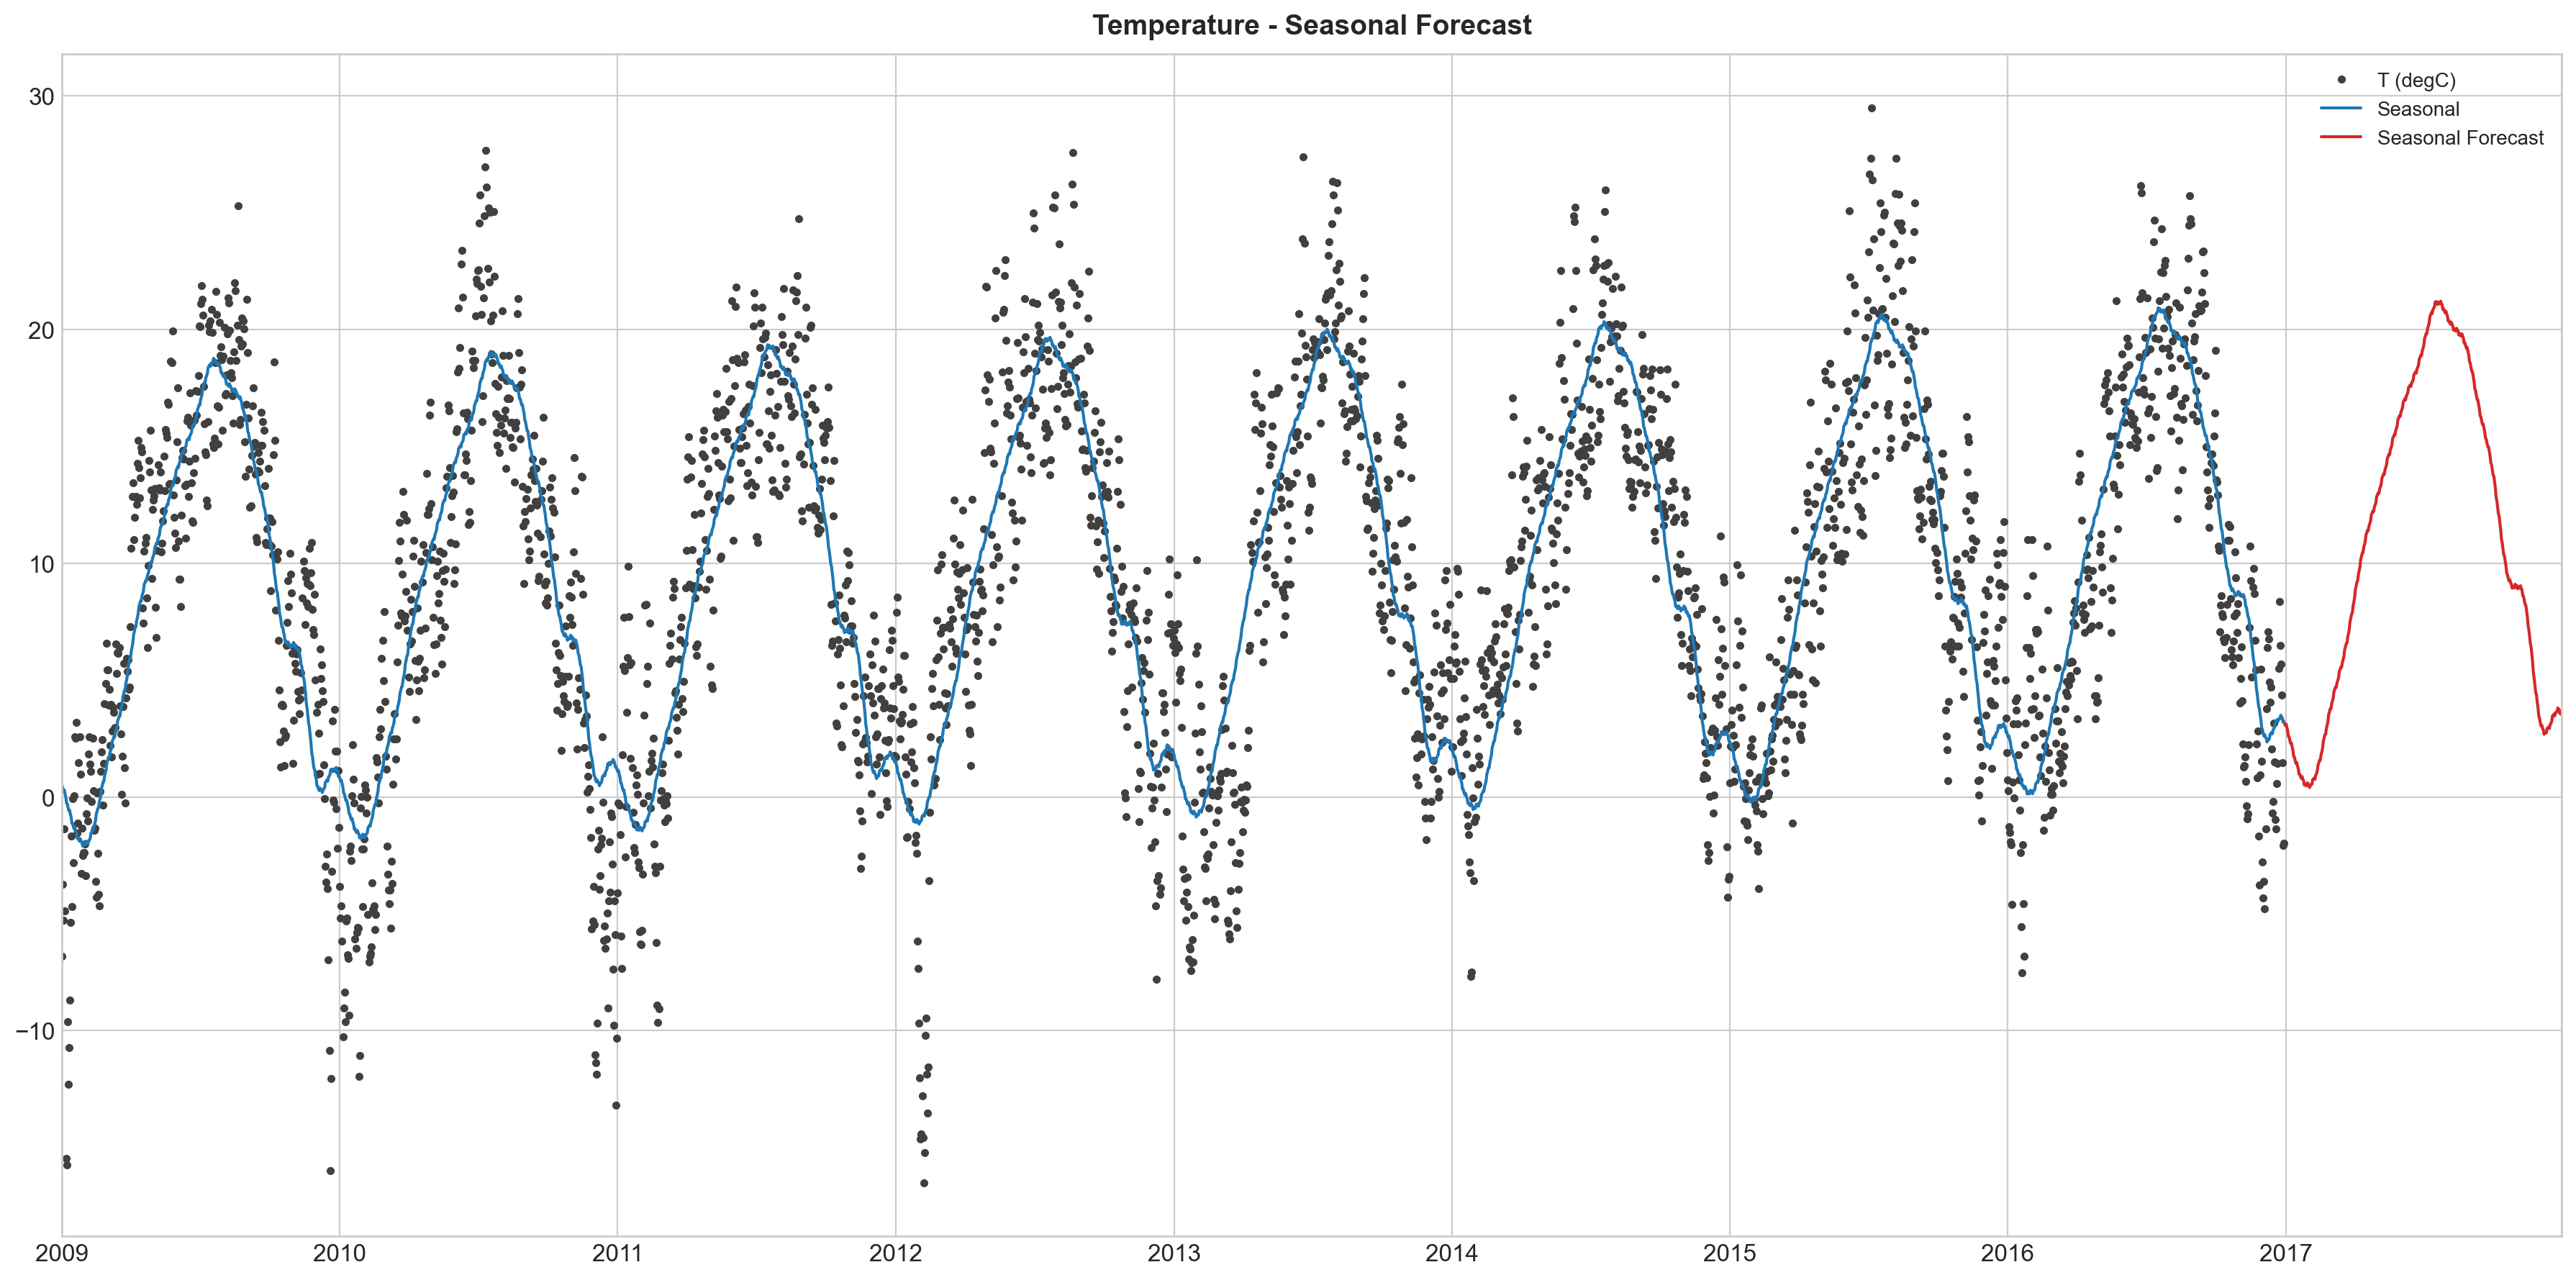

In [67]:
# Regression with Fourier Features added to the target

y = target_new_res["T (degC)"]
y = y.fillna(0)
print(y.isna().sum())

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=365)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Temperature - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

## 4.3 Multiple seasonality decomposition using LOESS (MSTL)

In [68]:
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult

res_mstl = MSTL(y, periods=(365, 182*4)).fit()
res_mstl.plot()
plt.tight_layout()
plt.show()

ImportError: cannot import name 'MSTL' from 'statsmodels.tsa.seasonal' (c:\Users\MRM\miniconda3\envs\modern_ts\lib\site-packages\statsmodels\tsa\seasonal.py)

# 5. Setting a Strong Forecast

In [2]:
#from statsmodels.tsa.holtwinters import ExponentialSmoothing
import time
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import os
import plotly.io as pio
pio.templates.default = "plotly_white"

from pathlib import Path
from tqdm.autonotebook import tqdm
import warnings
import humanize

#If importing darts is throwing an error, import torch beforehand and then import darts
# import torch
from darts import TimeSeries
from darts.models import (
    ExponentialSmoothing,
    #AutoARIMA,
    #ARIMA,
    Theta,
    FFT
)

from darts.metrics import mase, mse, mae, ope,mape,r2_score,rmse # Overall Percentage Error (OPE)
from darts.utils.utils import ModelMode, SeasonalityMode
from src.utils.ts_utils import forecast_bias
from src.utils.general import LogTime
from src.utils import plotting_utils
# %load_ext autoreload
# %autoreload 2
np.random.seed(42)
tqdm.pandas()

In [3]:
jena = pd.read_parquet('jena_climate_2009_2016.parquet')

jena['Date Time'] = pd.to_datetime(jena['Date Time'])

jena = jena.rename(columns = {'Date Time': 'Date','T (degC)':'T_degC' })

date = pd.date_range(start='2009-01-01 00:10:00', periods=jena.shape[0], freq='10T')

jena = jena.set_index(date)
jena = jena.drop(columns = ['Date'])

columns = ['p (mbar)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)', 'T_degC']
jena.head()


p (mbar)  T_degC  Tpot (K)  Tdew (degC)  rh (%)  \
2009-01-01 00:10:00    996.52   -8.02    265.40        -8.90    93.3   
2009-01-01 00:20:00    996.57   -8.41    265.01        -9.28    93.4   
2009-01-01 00:30:00    996.53   -8.51    264.91        -9.31    93.9   
2009-01-01 00:40:00    996.51   -8.31    265.12        -9.07    94.2   
2009-01-01 00:50:00    996.51   -8.27    265.15        -9.04    94.1   

                     VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
2009-01-01 00:10:00          3.33          3.11          0.22       1.94   
2009-01-01 00:20:00          3.23          3.02          0.21       1.89   
2009-01-01 00:30:00          3.21          3.01          0.20       1.88   
2009-01-01 00:40:00          3.26          3.07          0.19       1.92   
2009-01-01 00:50:00          3.27          3.08          0.19       1.92   

                     H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)  \
2009-01-01 00:10:00             3.12       1307.75      1.03           1.75   
2009-01-01 00:20:00             3.03       1309.80      0.72           1.50   
2009-01-01 00:30:00             3.02       1310.24      0.19           0.63   
2009-01-01 00:40:00             3.08       1309.19      0.34           0.50   
2009-01-01 00:50:00             3.09       1309.00      0.32           0.63   

                     wd (deg)  
2009-01-01 00:10:00     152.3  
2009-01-01 00:20:00     136.1  
2009-01-01 00:30:00     171.6  
2009-01-01 00:40:00     198.0  
2009-01-01 00:50:00     214.3

In [4]:
jena.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420451 entries, 2009-01-01 00:10:00 to 2016-12-29 19:10:00
Freq: 10T
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p (mbar)         420451 non-null  float64
 1   T_degC           420451 non-null  float64
 2   Tpot (K)         420451 non-null  float64
 3   Tdew (degC)      420451 non-null  float64
 4   rh (%)           420451 non-null  float64
 5   VPmax (mbar)     420451 non-null  float64
 6   VPact (mbar)     420451 non-null  float64
 7   VPdef (mbar)     420451 non-null  float64
 8   sh (g/kg)        420451 non-null  float64
 9   H2OC (mmol/mol)  420451 non-null  float64
 10  rho (g/m**3)     420451 non-null  float64
 11  wv (m/s)         420451 non-null  float64
 12  max. wv (m/s)    420451 non-null  float64
 13  wd (deg)         420451 non-null  float64
dtypes: float64(14)
memory usage: 48.1 MB


## 5.1 Create a train, val and test dataset

In [5]:
num_train_samples = int(0.6 * jena.shape[0])
num_val_samples = int(0.2 * jena.shape[0])
num_test_samples = jena.shape[0] - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 252270
num_val_samples: 84090
num_test_samples: 84091


In [29]:
ts_train = jena.iloc[:num_train_samples].drop_duplicates(keep='first').resample('D').mean()
ts_val = jena.iloc[num_train_samples:num_train_samples+num_val_samples].drop_duplicates(keep='first').resample('D').mean()
ts_test = jena.iloc[num_train_samples+num_val_samples:num_train_samples+num_val_samples+num_test_samples].drop_duplicates(keep='first').resample('D').mean()

In [30]:
ts_train.head()

p (mbar)    T_degC    Tpot (K)  Tdew (degC)     rh (%)  \
2009-01-01  999.145594 -6.810629  266.414545    -8.015594  91.086014   
2009-01-02  999.600625 -3.728194  269.463194    -4.824861  92.086806   
2009-01-03  998.548611 -5.271736  268.002292    -9.015833  76.458056   
2009-01-04  988.510694 -1.375208  272.685347    -2.897014  89.417361   
2009-01-05  990.405694 -4.867153  269.039306    -6.797292  86.260417   

            VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
2009-01-01      3.691119      3.355524      0.335315   2.091049   
2009-01-02      4.640069      4.267292      0.373056   2.659792   
2009-01-03      4.184792      3.107708      1.077014   1.937778   
2009-01-04      5.524306      4.938958      0.584861   3.114028   
2009-01-05      4.362708      3.806736      0.555625   2.397014   

            H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)    wd (deg)  
2009-01-01         3.357832   1305.178252  0.778601       1.378252  181.863077  
2009-01-02         4.268750   1290.353194  1.419514       2.227361  125.072014  
2009-01-03         3.111944   1297.117014  1.250903       2.065069  190.383333  
2009-01-04         4.997014   1264.634514  1.720417       3.564861  213.069861  
2009-01-05         3.847778   1284.372778  3.800278       5.940000  118.287361

In [31]:
train_stats = ts_train.describe().T
train_stats

count         mean        std          min          25%  \
p (mbar)         1752.0   988.741804   8.039022   955.510208   983.964965   
T_degC           1752.0     8.999152   8.266132   -16.503472     2.971910   
Tpot (K)         1752.0   283.078362   8.308868   256.056528   277.448021   
Tdew (degC)      1752.0     4.495415   7.012618   -19.431875    -0.215851   
rh (%)           1752.0    75.918330  11.376241    37.890278    67.719826   
VPmax (mbar)     1752.0    13.324362   6.899923     1.695417     7.681667   
VPact (mbar)     1752.0     9.331154   4.137252     1.307847     6.038403   
VPdef (mbar)     1752.0     3.993129   3.464537     0.000000     1.251233   
sh (g/kg)        1752.0     5.896563   2.623845     0.807569     3.815694   
H2OC (mmol/mol)  1752.0     9.439143   4.185293     1.297083     6.120764   
rho (g/m**3)     1752.0  1217.631911  39.185316  1134.182431  1188.162031   
wv (m/s)         1752.0     2.151224   0.929335     0.000000     1.492205   
max. wv (m/s)    1752.0     3.556990   1.411175     0.000000     2.549792   
wd (deg)         1752.0   173.627774  56.151672     0.000000   138.152934   

                         50%          75%          max  
p (mbar)          989.189965   993.965278  1011.180556  
T_degC              9.652951    15.548715    27.650764  
Tpot (K)          283.808681   289.525469   301.711181  
Tdew (degC)         5.163785     9.860747    20.200625  
rh (%)             76.869410    84.438368   100.000000  
VPmax (mbar)       12.192743    18.078351    38.606111  
VPact (mbar)        8.901424    12.240035    23.772778  
VPdef (mbar)        3.038194     5.818281    21.284306  
sh (g/kg)           5.599792     7.730104    15.118542  
H2OC (mmol/mol)     8.971701    12.369045    24.083472  
rho (g/m**3)     1211.846215  1242.769531  1367.870764  
wv (m/s)            1.927465     2.631337     7.612014  
max. wv (m/s)       3.282778     4.304392    11.417708  
wd (deg)          187.860417   212.963889   279.401389

In [32]:
# Normalize

ts_train_norm, ts_val_norm, ts_test_norm = ts_train.copy(), ts_val.copy(), ts_test.copy()
for col_name in columns:
    mean = train_stats.loc[col_name,'mean']
    std = train_stats.loc[col_name,'std']
    
    ts_train_norm.loc[:,col_name] = (ts_train_norm.loc[:,col_name] - mean)/std
    ts_val_norm.loc[:,col_name] = (ts_val_norm.loc[:,col_name] - mean)/std
    ts_test_norm.loc[:,col_name] = (ts_test_norm.loc[:,col_name] - mean)/std
    
ts_train_norm.tail()

p (mbar)    T_degC  Tpot (K)  Tdew (degC)    rh (%)  VPmax (mbar)  \
2013-10-14  0.570024 -0.276780 -0.321464    -0.105246  0.556832     -0.490644   
2013-10-15  0.357389 -0.129030 -0.157274     0.204097  1.042841     -0.324267   
2013-10-16 -0.695548  0.140115  0.194969     0.429266  0.695620     -0.124265   
2013-10-17 -0.311907 -0.015028  0.009224     0.234409  0.638246     -0.273854   
2013-10-18 -0.385040  0.211915  0.241785     0.495633  0.686119     -0.029139   

            VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
2013-10-14     -0.320288     -0.594677  -0.330688        -0.329505   
2013-10-15      0.035943     -0.688806   0.027962         0.029192   
2013-10-16      0.262090     -0.560482   0.273943         0.275690   
2013-10-17      0.029129     -0.580105   0.032620         0.034485   
2013-10-18      0.344980     -0.470089   0.351070         0.352789   

            rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
2013-10-14      0.385151 -0.464163      -0.591443  0.253443  
2013-10-15      0.182887 -0.917220      -0.980943  0.292328  
2013-10-16     -0.346726 -0.124240      -0.217641  0.612907  
2013-10-17     -0.098475 -0.609129      -0.579681  1.030231  
2013-10-18     -0.334344  1.499628       1.486460  0.554456

In [35]:
ts_val_norm.head()


p (mbar)    T_degC  Tpot (K)  Tdew (degC)    rh (%)  VPmax (mbar)  \
2013-10-18 -0.204815  0.227181  0.242603     0.486585  0.523735     -0.041553   
2013-10-19  0.402412  0.151927  0.119213     0.295410  0.186238     -0.112731   
2013-10-20  0.071967  0.132453  0.126426     0.288845  0.421328     -0.045892   
2013-10-21 -0.046846  0.748731  0.750617     1.066758  0.467507      0.582909   
2013-10-22  0.107281  0.764366  0.753693     0.955510  0.097774      0.611321   

            VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
2013-10-18      0.325456     -0.471385   0.327504         0.329228   
2013-10-19      0.098216     -0.341617   0.088332         0.089920   
2013-10-20      0.119382     -0.233959   0.116969         0.118410   
2013-10-21      1.139400     -0.199823   1.139668         1.139993   
2013-10-22      0.963945      0.066225   0.959695         0.960578   

            rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
2013-10-18     -0.304905  0.455049       1.154281  1.607650  
2013-10-19     -0.072378 -0.829792      -0.565706  0.920987  
2013-10-20     -0.127924  0.091641      -0.148008  0.166334  
2013-10-21     -0.764344  0.134084       0.052081  0.157490  
2013-10-22     -0.730740  0.833359       0.531833  0.651349

In [36]:
ts_val_norm.tail()


p (mbar)    T_degC  Tpot (K)  Tdew (degC)    rh (%)  VPmax (mbar)  \
2015-05-21 -0.727113  0.547803  0.605248    -0.258611 -2.316829      0.379022   
2015-05-22  0.241142  0.139720  0.120057     0.159762 -0.122086     -0.107699   
2015-05-23  1.232227  0.163058  0.064971    -0.274257 -1.333499     -0.039532   
2015-05-24  0.845693  0.491347  0.422127    -0.052257 -1.638331      0.311750   
2015-05-25  0.426876  0.749501  0.713146     0.583193 -0.850568      0.605555   

            VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
2015-05-21     -0.451431      1.293943  -0.441821        -0.440807   
2015-05-22     -0.045666     -0.159935  -0.051888        -0.050286   
2015-05-23     -0.474141      0.487578  -0.493193        -0.492045   
2015-05-24     -0.266139      0.938596  -0.281195        -0.279843   
2015-05-25      0.452691      0.665376   0.441236         0.442564   

            rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
2015-05-21     -0.675865  0.393604       0.466630  0.727500  
2015-05-22     -0.092487 -1.093346      -1.093044  0.303082  
2015-05-23      0.162443 -0.903694      -0.660140  0.228961  
2015-05-24     -0.243585 -0.876046      -0.845663 -0.815001  
2015-05-25     -0.612610  0.211400       0.377121 -2.254629

## 5.2 Using DARTS Library

In [ ]:
#%pip install u8darts[all]

### 5.2.1 Transform train, val and test datasets to Darts format

We are going to make it first for one variable T_degC, but with DARTS can be extended to other covariates.

In [63]:
pred_df = ts_val_norm.loc[:,'T_degC']
metric_record = []

ts_train_darts = TimeSeries.from_series(ts_train_norm.loc[:,'T_degC'], fill_missing_dates=True, freq='D') # '10min'
ts_val_darts = TimeSeries.from_series(ts_val_norm.loc[:,'T_degC'],fill_missing_dates=True, freq='D')
ts_test_darts = TimeSeries.from_series(ts_test_norm.loc[:,'T_degC'],fill_missing_dates=True, freq='D')

In [58]:
pred_df.head()

time
2013-10-18    0.227181
2013-10-19    0.151927
2013-10-20    0.132453
2013-10-21    0.748731
2013-10-22    0.764366
Freq: D, Name: T_degC, dtype: float64

In [39]:
ts_val_darts

<TimeSeries (DataArray) (time: 585, component: 1, sample: 1)>
array([[[ 0.22718086]],

       [[ 0.15192694]],

       [[ 0.13245323]],

       [[ 0.74873136]],

       [[ 0.76436577]],

       [[ 0.82228283]],

       [[ 0.8803091 ]],

       [[ 0.5859184 ]],

       [[ 0.32760195]],

       [[ 1.04899441]],

...

       [[ 0.2122131 ]],

       [[ 0.35108298]],

       [[ 0.4592721 ]],

       [[ 0.30460819]],

       [[ 0.92574214]],

       [[ 0.5478027 ]],

       [[ 0.13972017]],

       [[ 0.16305837]],

       [[ 0.49134743]],

       [[ 0.74950127]]])
Coordinates:
  * time       (time) datetime64[ns] 2013-10-18 2013-10-19 ... 2015-05-25
  * component  (component) object 'T_degC'
Dimensions without coordinates: sample

In [12]:
def eval_model(model, ts_train, ts_test, name=None):
    if name is None:
        name = type(model).__name__
    model.fit(ts_train)
    y_pred = model.predict(len(ts_test))
    return y_pred, {
        "Algorithm": name,
        "MAE": mae(actual_series = ts_test, pred_series = y_pred),
        "MSE": mse(actual_series = ts_test, pred_series = y_pred),
        "MASE": mase(actual_series = ts_test, pred_series = y_pred, insample=ts_train),
        "Forecast Bias": forecast_bias(actual_series = ts_test, pred_series = y_pred)
    }

def format_y_pred(y_pred, name):
    y_pred = y_pred.data_array().to_series()
    y_pred.index = y_pred.index.get_level_values(0)
    y_pred.name = name
    return y_pred

In [13]:
from itertools import cycle

def plot_forecast(pred_df, forecast_columns, forecast_display_names=None):
    if forecast_display_names is None:
        forecast_display_names = forecast_columns
    else:
        assert len(forecast_columns)==len(forecast_display_names)
    mask = ~pred_df[forecast_columns[0]].isnull()
    # colors = ["rgba("+",".join([str(c) for c in plotting_utils.hex_to_rgb(c)])+",<alpha>)" for c in px.colors.qualitative.Plotly]
    colors = [c.replace("rgb", "rgba").replace(")", ", <alpha>)") for c in px.colors.qualitative.Dark2]
    # colors = [c.replace("rgb", "rgba").replace(")", ", <alpha>)") for c in px.colors.qualitative.Safe]
    act_color = colors[0]
    colors = cycle(colors[1:])
    dash_types = cycle(["dash","dot","dashdot"])
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=pred_df[mask].index, y=pred_df[mask].T_degC,
                        mode='lines', line = dict(color=act_color.replace("<alpha>", "0.7")),
                        name='Temperature'))
    for col, display_col in zip(forecast_columns,forecast_display_names):
        fig.add_trace(go.Scatter(x=pred_df[mask].index, y=pred_df.loc[mask, col],
                            mode='lines', line = dict(dash=next(dash_types), color=next(colors).replace("<alpha>", "0.4")),
                            name=display_col))
    return fig

### 5.2.2 ETS

In [59]:
metric_record = []
metric_record


[]

In [16]:
def format_plot(fig, legends = None, xlabel="Time", ylabel="Value", title="", font_size=15):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t:  t.update(name = next(names)))
    fig.update_layout(
            autosize=False,
            width=900,
            height=500,
            title_text=title,
            title={
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            titlefont={
                "size": 20
            },
            legend_title = None,
            legend=dict(
                font=dict(size=font_size),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                title_text=ylabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            ),
            xaxis=dict(
                title_text=xlabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            )
        )
    return fig

In [54]:
name = "Exponential Smoothing"
from statsmodels.tools.sm_exceptions import ConvergenceWarning
# Suppress FutureWarning
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.simplefilter('ignore', ConvergenceWarning)
    ets_model = ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=508, random_state=42)
    with LogTime() as timer:
        y_pred, metrics = eval_model(ets_model, ts_train_darts, ts_val_darts, name=name)
    metrics['Time Elapsed'] = timer.elapsed
    
    
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "ets_preds_D_508_norm")
y_pred


Time Elapsed: 28 seconds


time
2013-10-19    0.584461
2013-10-20    0.586548
2013-10-21    0.681905
2013-10-22    0.755872
2013-10-23    0.093756
                ...   
2015-05-22    1.344083
2015-05-23    1.241794
2015-05-24    1.184999
2015-05-25    1.069175
2015-05-26    1.188365
Name: ets_preds_D_508_norm, Length: 585, dtype: float64

In [55]:
y_pred.index

DatetimeIndex(['2013-10-19', '2013-10-20', '2013-10-21', '2013-10-22',
               '2013-10-23', '2013-10-24', '2013-10-25', '2013-10-26',
               '2013-10-27', '2013-10-28',
               ...
               '2015-05-17', '2015-05-18', '2015-05-19', '2015-05-20',
               '2015-05-21', '2015-05-22', '2015-05-23', '2015-05-24',
               '2015-05-25', '2015-05-26'],
              dtype='datetime64[ns]', name='time', length=585, freq=None)

In [56]:
y_pred.name

'ets_preds_D_508_norm'

In [64]:
metrics

{'Algorithm': 'Exponential Smoothing',
 'MAE': 1.0463875402714076,
 'MSE': 1.5448657865453415,
 'MASE': 4.608530565631393,
 'Forecast Bias': 14203.215950193755,
 'Time Elapsed': 28.361018896102905}

In [66]:
pred_df = pd.concat((pred_df,y_pred), axis=1).dropna()
pred_df

T_degC  ets_preds_D_508_norm
time                                      
2013-10-19  0.151927              0.584461
2013-10-20  0.132453              0.586548
2013-10-21  0.748731              0.681905
2013-10-22  0.764366              0.755872
2013-10-23  0.822283              0.093756
...              ...                   ...
2015-05-21  0.547803              1.389051
2015-05-22  0.139720              1.344083
2015-05-23  0.163058              1.241794
2015-05-24  0.491347              1.184999
2015-05-25  0.749501              1.069175

[584 rows x 2 columns]

In [72]:
#forecast_columns = ['T_degC']

fig = plot_forecast(pred_df, forecast_columns=["ets_preds_D_508_norm"], forecast_display_names=['Exponential Smoothing Predictions'])
fig = format_plot(fig, title=f"Exponential Smoothing: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2013-10-18", "2015-05-25"])
fig.write_image("ets.png")
fig.show()

## Theta

In [81]:
from statsmodels.tools.sm_exceptions import ConvergenceWarning

name = "Theta"
theta_model = Theta(theta=3, seasonality_period=100, season_mode=SeasonalityMode.ADDITIVE)
# Suppress FutureWarning
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.simplefilter('ignore', ConvergenceWarning)
    with LogTime() as timer:
        y_pred, metrics = eval_model(theta_model, ts_train_darts, ts_val_darts, name=name)
    metrics['Time Elapsed'] = timer.elapsed
    metric_record.append(metrics)
    y_pred = format_y_pred(y_pred, "theta_preds_100D")
    pred_df = pred_df.join(y_pred)   

Time Elapsed: 0 microseconds


In [82]:
fig = plot_forecast(pred_df, forecast_columns=["theta_preds_100D"], forecast_display_names=['Theta Predictions'])
fig = format_plot(fig, title=f"Theta Predictions: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2013-10-18", "2015-05-25"])
fig.write_image("theta_preds_100D.png")
fig.show()

## FFT

In [86]:
name = "FFT"
fft_model = FFT(nr_freqs_to_keep=35, trend="poly", trend_poly_degree=2)
# Suppress FutureWarning
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.simplefilter('ignore', ConvergenceWarning)
    with LogTime() as timer:
        y_pred, metrics = eval_model(fft_model, ts_train_darts, ts_val_darts, name=name)
    metrics['Time Elapsed'] = timer.elapsed
    metric_record.append(metrics)
    y_pred = format_y_pred(y_pred, "fft_preds_2rd")
    pred_df = pred_df.join(y_pred)   

Time Elapsed: 0 microseconds


In [87]:
pred_df

T_degC  ets_preds_D_508_norm  theta_preds_2  fft_preds  \
time                                                                   
2013-10-19  0.151927              0.584461       0.581365  -0.121424   
2013-10-20  0.132453              0.586548       0.586636  -0.110183   
2013-10-21  0.748731              0.681905       0.684959  -0.092518   
2013-10-22  0.764366              0.755872       0.760594  -0.070947   
2013-10-23  0.822283              0.093756       0.099907  -0.048328   
...              ...                   ...            ...        ...   
2015-05-21  0.547803              1.389051       0.348874   1.639748   
2015-05-22  0.139720              1.344083       0.297496   1.608694   
2015-05-23  0.163058              1.241794       0.187876   1.577909   
2015-05-24  0.491347              1.184999       0.123436   1.549860   
2015-05-25  0.749501              1.069175      -0.000706   1.526732   

            theta_preds_14D  theta_preds_1016D  theta_preds_100D  \
time                                                               
2013-10-19         0.214935           0.194250          0.194250   
2013-10-20         0.218765           0.299993          0.299993   
2013-10-21         0.195694           0.393607          0.393607   
2013-10-22         0.204354           0.535700          0.535700   
2013-10-23         0.206656           0.506841          0.506841   
...                     ...                ...               ...   
2015-05-21         0.329875           0.418322          0.418322   
2015-05-22         0.329338           0.336494          0.336494   
2015-05-23         0.311582           0.262432          0.262432   
2015-05-24         0.318026           0.211088          0.211088   
2015-05-25         0.309227           0.244166          0.244166   

            fft_preds_3rd  fft_preds_2rd  
time                                      
2013-10-19      -0.093200      -0.121424  
2013-10-20      -0.070755      -0.110183  
2013-10-21      -0.041819      -0.092518  
2013-10-22      -0.009039      -0.070947  
2013-10-23       0.024613      -0.048328  
...                   ...            ...  
2015-05-21       4.473195       1.639748  
2015-05-22       4.447174       1.608694  
2015-05-23       4.421612       1.577909  
2015-05-24       4.398963       1.549860  
2015-05-25       4.381408       1.526732  

[584 rows x 9 columns]

In [88]:
fig = plot_forecast(pred_df, forecast_columns=["fft_preds_2rd"], forecast_display_names=['FFT Predictions'])
fig = format_plot(fig, title=f"FFT: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2013-10-18", "2015-05-25"])
fig.write_image("fft.png")
fig.show()

In [90]:
metric_styled = pd.DataFrame(metric_record).style.format({"MAE": "{:.3f}", 
                          "MSE": "{:.3f}", 
                          "MASE": "{:.3f}", 
                          "Forecast Bias": "{:.2f}%"}).highlight_min(color='green', subset=["MAE","MSE","MASE","Time Elapsed"])
display(metric_styled)

# 6 Forecasting with Machine Learning Models.

## 6.1 Feature Preparation for ML models

## 6.2 Target Preparation for ML models

## 6.3 Ensembling and Stacking

## 6.4 Global forecasting models

# 7 Forecasting with Deep Learning Models.

## 7.1 RNN, GRU, LSTM, CONV1D

## 7.2 Attention and transformers for time series

## 7.3 Strategies for Global Deep Learning Forecasting Models

## 7.4 Specialized Architectures in Forecasting (N-Beats / N-HiTS)